# **<center>Vision-Based Fire Detection Using a Frame Referencing 3D CNN </center>**




---

<center>By Theodore Psillos </center>
<center>Last Modified: 3rd November 2022</center>

---



**Here are the steps that this notebook performs:**

- **Step 1: Import all packages that will be needed/used namely "youtube-dl" and "visualkeras"**
- **Step 2: Visualize the Dataset with its Labels**
- **Step 3: Read, Format and Preprocess the Dataset**
- **Step 4: Split the Data into Train and Test Set**
- **Step 5: Construct the Model**
- **Step 6: Compile & Train the Model**
- **Step 7: Plot Model’s Loss & Accuracy Curves**
- **Step 8: Make Predictions with the Model**

It must be noted that this code has been adapted from the following website: https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition/ posted by Taha Anwar on 8th March 2021

## **Step 1: Import all Packages & Libraries needed for this Notebook**
#### **Import the required Packages**
- *`youtube-dl`*
- *`moviepy`* 
- *`visualkeras`*

In [1]:
!pip install pafy youtube-dl moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 74.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 67.2 MB/s eta 0:00:0000:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110728 sha256=87706bae368fd20b2babe79ea5da238e0ca282bc40d6d10bf1d55969cf9716a0
  Stored in directory: /root/.cache/pip/wheels/29/15/e4/4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [2]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 kB 80.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


#### **Import Required Libraries:**

In [3]:
# General libraries that are needed
import os
import cv2
import math
import pafy
import random
import numpy as np
import array as arr
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import library used to visualise the model created
import visualkeras\

# Import the libraries used to display the predictions on youtube videos
from moviepy.editor import *
from collections import deque
from IPython.display import Image, display
from PIL import Image as im
%matplotlib inline

# Import the various libraries needed to create the model and to implement testing
from keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Import various libraries used for model evaluation and metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import backend as K

# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model

#### **Edits Made to the *`youtube-dl`* Package**
The *`youtube-dl`* package requires changes to be made to it so that it works. With the introduction of the dislike button in youtube the following instructions below must be followed so that the package works accordingly:
1. Type the following command in terminal **`cd /usr/local/lib/python3.9/dist-packages/pafy`**
2. Access the backend youtube_dl file **`vim backend_youtube_dl.py`**
3. Locate lines 54 & 55
4. Press **`i`** to insert or change the file
5. Change lines 54 & 55 to:
    - **`self._likes = self._ydl_info.get('like_count',0)`**  --> 54
    - **`self._dislikes = self._ydl_info.get('dislike_count',0)`**  -->55
6. Press escape to exit editing mode in terminal
7. **`:wq`** (to save and quit)
8. Restart the kernal

Check that the changes made are working by displaying details of a random YouTube video

In [2]:
url = "https://www.youtube.com/watch?v=bMt47wvK6u0"
video = pafy.new(url)
print(video)

Title: Richard Jones: Introduction to game programming - PyCon 2014
Author: PyCon 2014
ID: bMt47wvK6u0
Duration: 02:53:14
Rating: None
Views: 58379
Thumbnail: http://i.ytimg.com/vi/bMt47wvK6u0/default.jpg


**Set Numpy, Python & Tensorflow seeds to get consistent results.**

In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **Step 2: Visualize the Data with its Labels**
Select random frames from each of the videos within the classes. 

Note the following command must be run if you are working in notebooks so as to remove the automatic checkpoints from appearing in dataset. You must be at the root folder in terminal when executing this command:
- **rm -rf \`find -type d -name .ipynb_checkpoints\`**

['Nofirenosmoke2', 'Nofirenosmoke3', 'Fireandsmoke2', 'Fireandsmoke3', 'Nofirenosmoke']


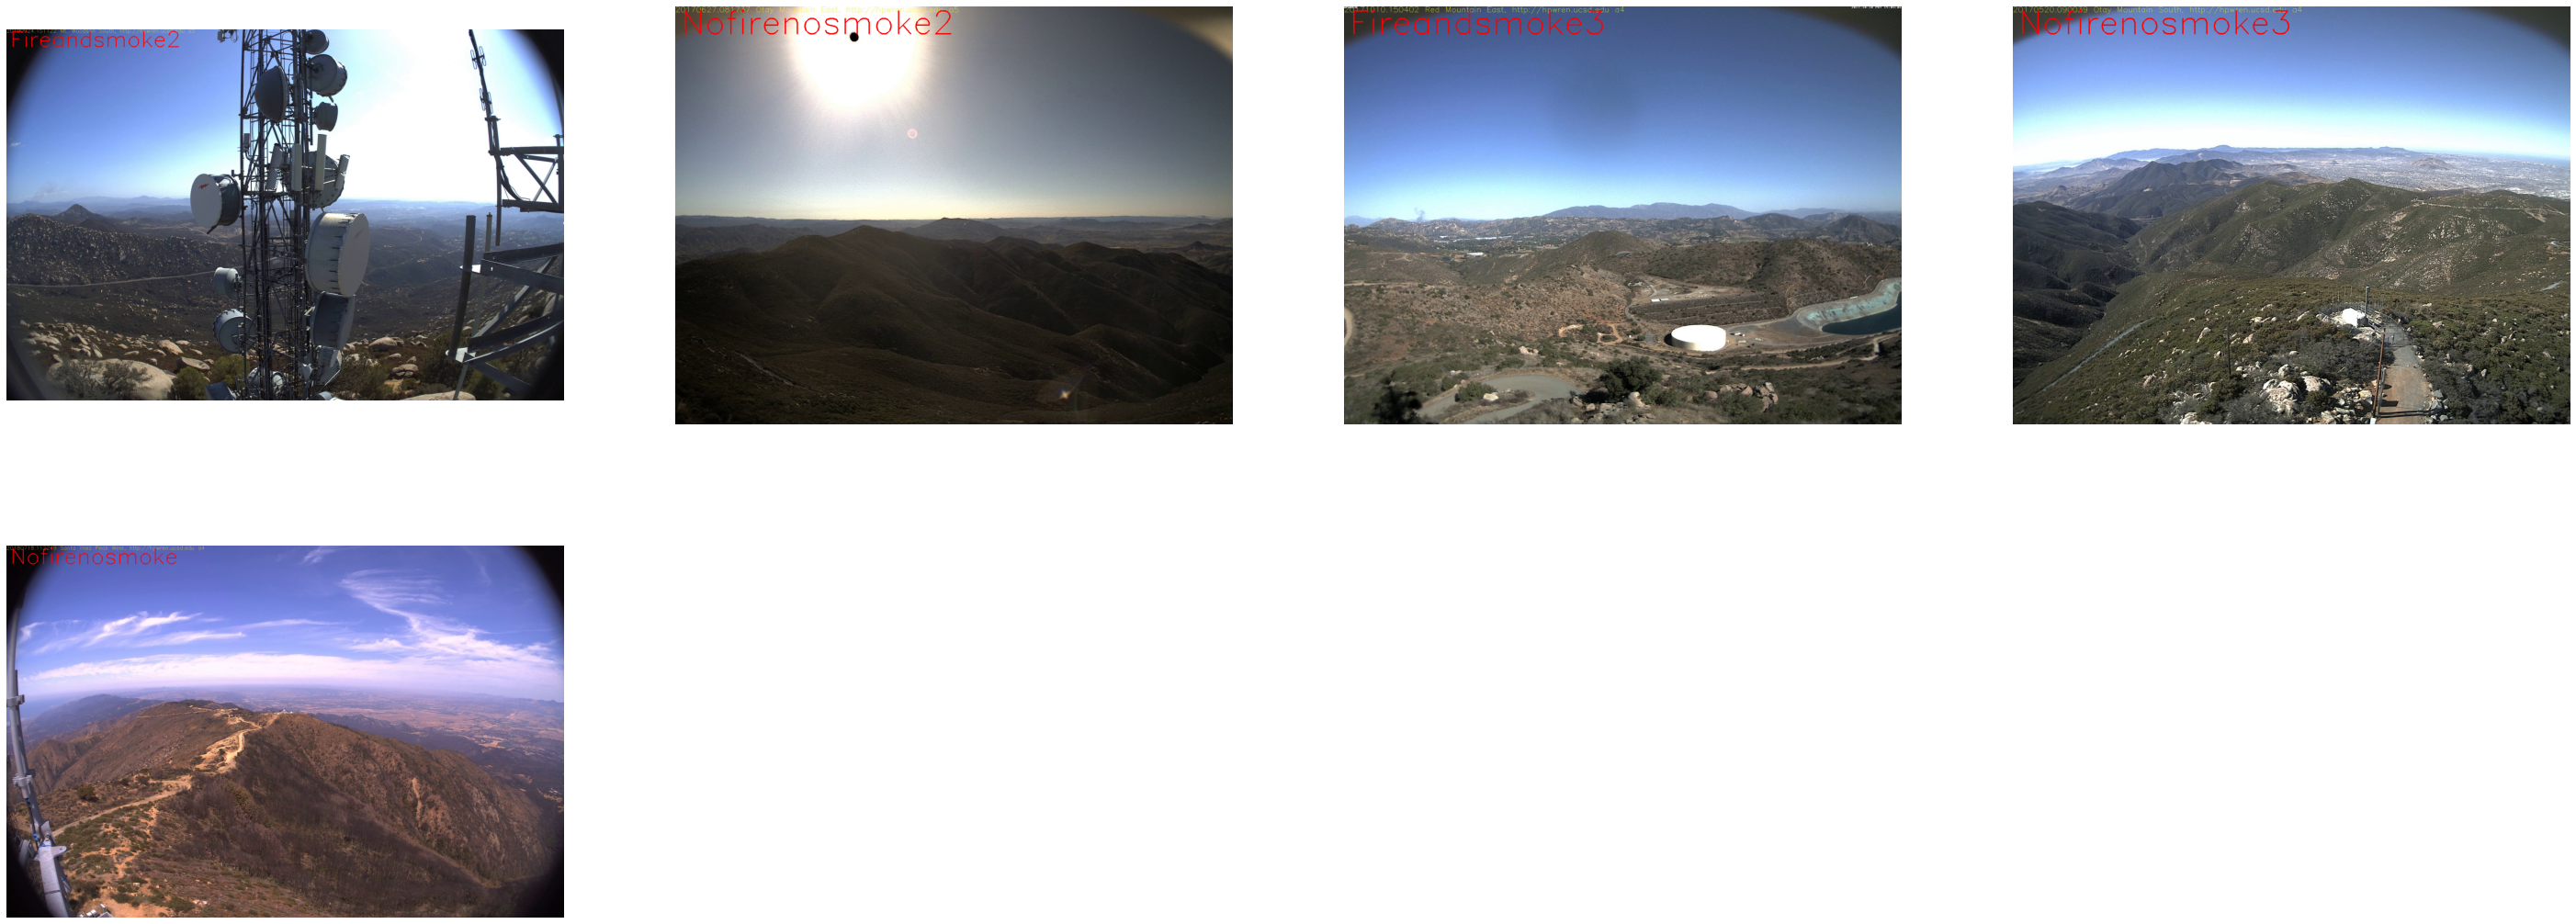

In [5]:
# Create a Matplotlib figure
plt.figure(figsize = (50, 50))

# Get Names of all classes in VideoDataset
all_classes_names = os.listdir('VideoDataset7')

print(all_classes_names)

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 5)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'VideoDataset7/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'VideoDataset7/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 3)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

## **Step 3: Read, Format & Preprocess the Dataset**

It is important to create a dataset so that it is in the right format to be fed into your model.

Some of the constants that are used are defined below: 
- **`image_height`** and **`image_weight`**: This is the size we will resize all frames of the video to, we're doing this to avoid unneccsary computation.

- **`max_images_per_class`**: Maximum number of training images allowed for each class.

- **`dataset_directory`**: The path of the directory containing the extracted dataset. 

- **`classes_list`**: These are the list of classes that are going to be training on. 

**Note:** The `image_height`, `image_weight` and `max_images_per_class` constants may be increased for better results, but be warned this will become computationally expensive.

In [4]:
image_height, image_width = 80, 80
max_images_per_class = 1230*3
image_depth = 2

dataset_directory = "VideoDataset7"
classes_list = ["Nofirenosmoke2", "Fireandsmoke2"]

model_output_size = len(classes_list)

Determine the number of frames for the above selected classes

In [5]:
number_of_frames = arr.array('i', [0, 0])

for class_index, class_name in enumerate(classes_list):        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:
            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            
            video_reader = cv2.VideoCapture(video_file_path)
    
            if classes_list[0] in video_file_path:
                number_of_frames[0] += int(video_reader.get(cv2. CAP_PROP_FRAME_COUNT))

            else:
                number_of_frames[1] += int(video_reader.get(cv2. CAP_PROP_FRAME_COUNT))
                
print("The Number of Frames in the " + classes_list[0] + " is: " + str(number_of_frames[0]))
print("The Number of Frames in the " + classes_list[1] + " is: " + str(number_of_frames[1]))

The Number of Frames in the Nofirenosmoke2 is: 1746
The Number of Frames in the Fireandsmoke2 is: 3394


### **Extract, Resize, Normalize & Format Frames**


The function below extracts frames from each video while performing other preprocessing operation like the resizing, normalizing and formatting if frames. 

This method takes a video file path as input. It then reads the video file frame by frame, resizes each frame, normalizes the resized frame, appends the normalized frame into a list and then finally returns that list.

In [5]:
def channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    img = img.astype(np.uint8)
    return img

def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img

In [6]:
def reference_frames_extraction(video_path, resize = (image_height, image_width)):
    # Empty List declared to store video frames
    frames_list = []
    frames_dummy = []
    frames_window = [] 
    reference_frame = []
        
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
    
    # Collect the total number of frames for a particular video
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # Number of frames from video header while count frames is the number of frames read in from the video file
    
    # Iterator for creating the depth of a multiple images
    i = 0
    count_frames = 0
    window_incrementer = 0
    
    # Iterating through Video Frames
    while True:           
        # Reading a frame from the video file 
        success, frame = video_reader.read() 
    
        # If Video frame was not successfully read then break the loop
        if not success:
            break
        
        # Resize the Frame to fixed where the first dimension is 240 height, for each height there are 240 widths (i.e. 240 rows and columns) and 3 RGB values for each point
        resized_frame = cv2.resize(frame, resize)
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # add frames to frames window array until depth of image created has been reached
        if count_frames == 0:
            reference_frame.extend(normalized_frame)
            
        else:
            # frames_window.append(reference_frame)
            frames_window.append(normalized_frame) # frames_window has a shape of total_frames x image_height x image_width x RGB_channel
            frames_window.append(horizontal_flip(normalized_frame, 1))
            frames_window.append(channel_shift(normalized_frame, 6))
            
        count_frames += 1 
    
    while window_incrementer < (count_frames-1)*3:
        # Create array of 3D frames of size (Image_Height=240)x(Image_width=240)x(Image_depth=4)x(RGB_Channel=3)
        for x in range(image_height):
            frames_dummy.append([])
            
            for y in range(image_width):
                frames_dummy[x].append([])
                
                for z in range(image_depth):
                    if z == 0:
                        frames_dummy[x][y].append(np.asarray(frames_window[window_incrementer][x][y]))
                    else:
                         frames_dummy[x][y].append(np.asarray(reference_frame[x][y]))
            
        frames_list.append(np.asarray(frames_dummy))
                                          
        # frames_window.clear()
        frames_dummy.clear()
            
        # Reset the number of frames loaded & increment the window incrementer
        window_incrementer += 1
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
    
    # returning the frames list 
    frames_list = np.asarray(frames_list)
    reference_frame = np.asarray(reference_frame)
    length_frames = len(frames_list)
    
    # print(reference_frame.shape)
    
    return frames_list, length_frames, reference_frame

In [9]:
def frames_extraction(video_path, reference_frame, resize = (image_height, image_width)):
    # Empty List declared to store video frames
    frames_list = []
    frames_dummy = []
    frames_window = [] 
        
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
    
    # Collect the total number of frames for a particular video
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # Number of frames from video header while count frames is the number of frames read in from the video file
    
    # Iterator for creating the depth of a multiple images
    i = 0
    count_frames = 0
    window_incrementer = 0
    
    # Iterating through Video Frames
    while True:           
        # Reading a frame from the video file 
        success, frame = video_reader.read() 
    
        # If Video frame was not successfully read then break the loop
        if not success:
            break
        
        # Resize the Frame to fixed where the first dimension is 240 height, for each height there are 240 widths (i.e. 240 rows and columns) and 3 RGB values for each point
        resized_frame = cv2.resize(frame, resize)
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # add frames to frames window array until depth of image created has been reached
        # frames_window.append(reference_frame)
        frames_window.append(normalized_frame) # frames_window has a shape of total_frames x image_height x image_width x RGB_channel
        frames_window.append(horizontal_flip(normalized_frame, 1))
        frames_window.append(channel_shift(normalized_frame, 6))
                   
        count_frames += 1 
    
    while window_incrementer < (count_frames-1)*3:
        # Create array of 3D frames of size (Image_Height=240)x(Image_width=240)x(Image_depth=4)x(RGB_Channel=3)
        for x in range(image_height):
            frames_dummy.append([])
            
            for y in range(image_width):
                frames_dummy[x].append([])
                
                for z in range(image_depth):
                    if z == 0:
                        frames_dummy[x][y].append(np.asarray(frames_window[window_incrementer][x][y]))
                    else:
                         frames_dummy[x][y].append(np.asarray(reference_frame[x][y]))
            
        frames_list.append(np.asarray(frames_dummy))
                                          
        # frames_window.clear()
        frames_dummy.clear()
            
        # Reset the number of frames loaded & increment the window incrementer
        window_incrementer += 1
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
    
    # returning the frames list 
    frames_list = np.asarray(frames_list)
    length_frames = len(frames_list)
    
    return frames_list, length_frames

### **Dataset Creation**
Another function is created that is called  **`create_dataset()`**,  this function uses the **`frame_extraction()`** funciton above and creates the final preprocessed dataset. 

**Here's how the function works:**

1.   Iterate through all the classes mentioned in the `classes_list`
2.   Now for each class iterate through all the video files present in it. 
3.   Call the **frame_extraction** method on each video file.
4.   Add the returned frames to a list called `temp_features`
5.   After all videos of a class are processed, randomly select video frames (equal to **max_images_per_class**) and add them to the list called `features`.
6.   Add labels of the selected videos to the labels list.
7.   After all videos of all classes are processed then return the features and labels as numpy arrays.


So when this function is called, it returns **2** lists:
- a list of feature vectors 
- a list of it's associated labels.


In [7]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    temp_first_frame = []
    first_frame = []
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        total_frames = 0
        first_frame_index = 0
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
        
        if "Nofirenosmoke" in class_name:
            # Iterating through all the files present in the files list
            for file_name in files_list:
                # Construct the complete video path
                video_file_path = os.path.join(dataset_directory, class_name, file_name)

                # Calling the frame_extraction method for every video file path
                frames, length_frames, reference_frame = reference_frames_extraction(video_file_path)

                total_frames += length_frames

                # Appending the frames to a temporary list.
                temp_features.extend(frames)
                first_frame.append(reference_frame)
            
        else:
            # Iterating through all the files present in the files list
            for file_name in files_list:

                # Construct the complete video path
                video_file_path = os.path.join(dataset_directory, class_name, file_name)

                # Calling the frame_extraction method for every video file path
                frames, length_frames = frames_extraction(video_file_path, first_frame[first_frame_index])

                total_frames += length_frames
                first_frame_index += 1 
                                                                                       
                # Appending the frames to a temporary list.
                temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))
        
        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()
        
        print("The Total Number of Frames of " + str(class_name) + " is: " + str(total_frames))
        print("The Total Length of Features " + str(class_name) + " is: " + str(len(features)))
        
    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

Calling the **create_dataset** method which returns features and labels.

In [10]:
features, labels = create_dataset()

Extracting Data of Class: Nofirenosmoke2
The Total Number of Frames of Nofirenosmoke2 is: 4959
The Total Length of Features Nofirenosmoke2 is: 3690
Extracting Data of Class: Fireandsmoke2
The Total Number of Frames of Fireandsmoke2 is: 3702
The Total Length of Features Fireandsmoke2 is: 7380


Now the class labels are converted to one hot encoded vectors.

In [11]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **Step 4: Split the Data into Train and Test Set**
There are 2 numpy arrays, one containing all images, the second one contains all class labels in one hot encoded format. 

The data can now be split to create a training and testing set. It’s important that the data is shuffled before the split which was already done in the *`createdataset()`* function.


In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

# View the shape of the train and test data/labels
print(f"train_data in train set: {len(features_train)}")
print(f"train_labels in train set: {labels_train.shape}")
print(f"test_data in train set: {len(features_test)}")
print(f"test_labels in train set: {labels_test.shape}")

print()
print(f"train_data each index: {features_train[0].shape}")

train_data in train set: 5904
train_labels in train set: (5904, 2)
test_data in train set: 1476
test_labels in train set: (1476, 2)

train_data each index: (80, 80, 2, 3)


## **Step 5: Construct the 2D CNN Model**
The 2D CNN model can be created with a basic model consisting of 2 Convolutional layers being used.

*`Batch Normalisation`* 
- Normalises the outputs of activations/weights to a range of 0 to 1 so as to prevent any large outliers that could
  effect the training of the model

*`Batch Size`* 
- The size which a class's dataset is split up into. 
- Larger Batch size means the faster an epoch is completed but bigger batch sizes means poorer generalisation of 
  the model (hyperparamater tuned)

*`Epoch`* 
- A full iteration of all the batches. If the class size is 1000 with batch size = 10, 1 epoch will have 100 iterations 
  of the each batch

*`MaxPooling`* 
- Reduces the dimension of the output of a Convolutional Layer
- Reduces number of parameters in network and computational load by reducing the resolution of each frame
- It helps reduce the possibility of overfitting
- Higher valued pixels are the most activitated pixels so want to preserve these values & discard the lower 
  less activated pixels

*`AveragePooling`*
- Same but takes the average of the output layer but not as commonly used

*`Conv2D`* 
- CNN's kernels identify patterns (edges, shapes, objects) in images well
- First few filters detect edges while the deeper Conv2D layers are able to detect whole sophisticated objects
- Conv2D((no. of filters), filter size)

In [13]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()
    
    # Defining The Model Architecture
    # kernel_regularizer = regularizers.L1(0.0001), bias_regularizer = regularizers.L2(0.0001), ---> Regularizers
    model.add(Conv3D(filters = 64, kernel_size = (3, 3, 1),  activation = 'relu', input_shape = (image_height, image_width, image_depth, 3))) # height, width, Depth, RGB (channels), fps
    model.add(MaxPooling3D(pool_size = (2, 2, 1)))
    model.add(BatchNormalization())
    
    model.add(Conv3D(filters = 64, kernel_size = (3, 3, 1), activation = 'relu')) # padding = 'same'
    model.add(MaxPooling3D(pool_size = (2, 2, 1)))
    
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'sigmoid')) # softmax
    
    # Printing the models summary
    model.summary()

    return model

# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 78, 78, 2, 64)     1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 39, 39, 2, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 39, 39, 2, 64)    256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 37, 37, 2, 64)     36928     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 18, 18, 2, 64)    0         
 3D)                                                             
                                                        

### **Check Model’s Structure:**
The **`visualkeras`** library can be used to check the structure of the final model. This helps visualise complext networks to ensure they have been constructed correctly.

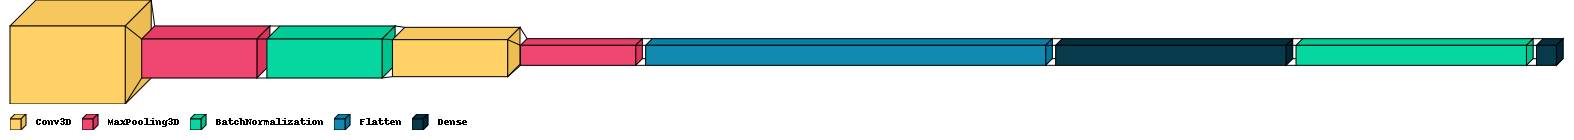

In [14]:
visualkeras.layered_view(model, legend = True, scale_xy=1, scale_z=0.9, to_file = 'ModelVisualisation/Visualisation_of_3D_FrameReferencing_Model.png')

## **Step 6: Compile & Train the Model**


Before the training of the model can be started the model must be conpiled.


In [5]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss':[],'val_loss':[], 'accuracy':[],'val_accuracy':[], 'loss_avg':[],'val_loss_avg':[], 'accuracy_avg':[],'val_accuracy_avg':[]}

    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, epoch, logs={}):
        self.history['loss_avg'].append(logs.get('loss'))
        self.history['val_loss_avg'].append(logs.get('val_loss'))
        self.history['accuracy_avg'].append(logs.get('accuracy'))
        self.history['val_accuracy_avg'].append(logs.get('val_accuracy'))

In [18]:
num_folds = 6
kfold = KFold(n_splits=num_folds, shuffle=True)

inputs = np.concatenate((features_train, features_test), axis=0)
targets = np.concatenate((labels_train, labels_test), axis=0)

fold_no = 1

acc_training = []
acc_validation = []
acc_train_average = []
loss_training = []
loss_validation = []
loss_train_average = []

acc = []
loss1 = []
f1_score1 = []
precision1 = []
recall1 = []

for train, test in kfold.split(inputs, targets):
   # We will use a Sequential model for model construction
    model = Sequential()
    
    # Defining The Model Architecture
    model.add(Conv3D(filters = 64, kernel_size = (3, 3, 1),  activation = 'relu', input_shape = (image_height, image_width, image_depth, 3))) # height, width, Depth, RGB (channels), fps
    model.add(MaxPooling3D(pool_size = (2, 2, 1)))
    model.add(BatchNormalization())
    
    model.add(Conv3D(filters = 64, kernel_size = (3, 3, 1), activation = 'relu')) # padding = 'same'
    model.add(MaxPooling3D(pool_size = (2, 2, 1)))
    
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'sigmoid')) # softmax
    
    # Adding the Early Stopping Callback to the model which will continuously monitor the validation loss metric for every epoch.
    # If the models validation loss does not decrease after 15 consecutive epochs, the training will be stopped and the weight which reported the lowest validation loss will be retored in the model.
    early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
    history = LossHistory()
    
    loss_fn = tf.keras.losses.BinaryCrossentropy(reduction='auto')
    model.compile(loss = loss_fn, optimizer = 'Adam', metrics = ['accuracy', f1_m, precision_m, recall_m]) # metrics = ['accuracy', f1_m, precision_m, recall_m]
     
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Adding loss, optimizer and metrics values to the model.
    model.fit(inputs[train], targets[train], epochs = 50, batch_size = 32, shuffle = True, validation_split = 0.2, callbacks = [history]) # 50 for each
        
    loss, accuracy, f1_score, precision, recall = model.evaluate(inputs[test], targets[test], verbose=0)
    # loss, accuracy = model.evaluate(inputs[test], targets[test], verbose=0)
    
        
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {loss}; {model.metrics_names[1]} of {accuracy*100}%')
    print()
    
    acc_train = history.history['accuracy']
    loss_train = history.history['loss']
    
    batch = 154 # 125 depth 6 and 144 depth 4
    
    for i in range(len(loss_train)//batch):
        loss1.append(loss_train[batch*i : batch+batch*i])
        acc.append(acc_train[batch*i : batch+batch*i])      
    
    # Append training loss and accuracy values for each batch of each fold
    loss_training.append(loss1)
    acc_training.append(acc)
    
    # Append the training loss and accuracy values for each epoch of each fold
    loss_train_average.append(history.history['loss_avg'])
    acc_train_average.append(history.history['accuracy_avg'])
    
    # Append the validation loss and accuracy values for each epoch of each fold
    loss_validation.append(history.history['val_loss_avg']) 
    acc_validation.append(history.history['val_accuracy_avg'] )    
    
    f1_score1.append(f1_score * 100)
    precision1.append(precision * 100)
    recall1.append(recall * 100)

    # Save the Model
    model.save(f'ModelsResults/Conv3D_ReferenceFrame/Model_Conv3D_ReferenceFrame_FoldNo_{fold_no}_Loss_{loss}_Accuracy_{accuracy}.h5')
    
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
154/154 [==============================] - 4s 26ms/step - loss: 0.6922 - accuracy: 0.5675 - f1_m: 0.5700 - precision_m: 0.5702 - recall_m: 0.5710 - val_loss: 0.6940 - val_accuracy: 0.5846 - val_f1_m: 0.5922 - val_precision_m: 0.5574 - val_recall_m: 0.6327
Epoch 2/50
154/154 [==============================] - 4s 24ms/step - loss: 0.5293 - accuracy: 0.7801 - f1_m: 0.7672 - precision_m: 0.7739 - recall_m: 0.7622 - val_loss: 0.6797 - val_accuracy: 0.5293 - val_f1_m: 0.5681 - val_precision_m: 0.5430 - val_recall_m: 0.5966
Epoch 3/50
154/154 [==============================] - 3s 22ms/step - loss: 0.3607 - accuracy: 0.8467 - f1_m: 0.8445 - precision_m: 0.8447 - recall_m: 0.8452 - val_loss: 0.5992 - val_accuracy: 0.6138 - val_f1_m: 0.6128 - val_precision_m: 0.6084 - val_recall_m: 0.6177
Epoch 4/50
154/154 [==============================] - 4s 24ms/step - loss: 0.3077 - accuracy: 0.8490 -

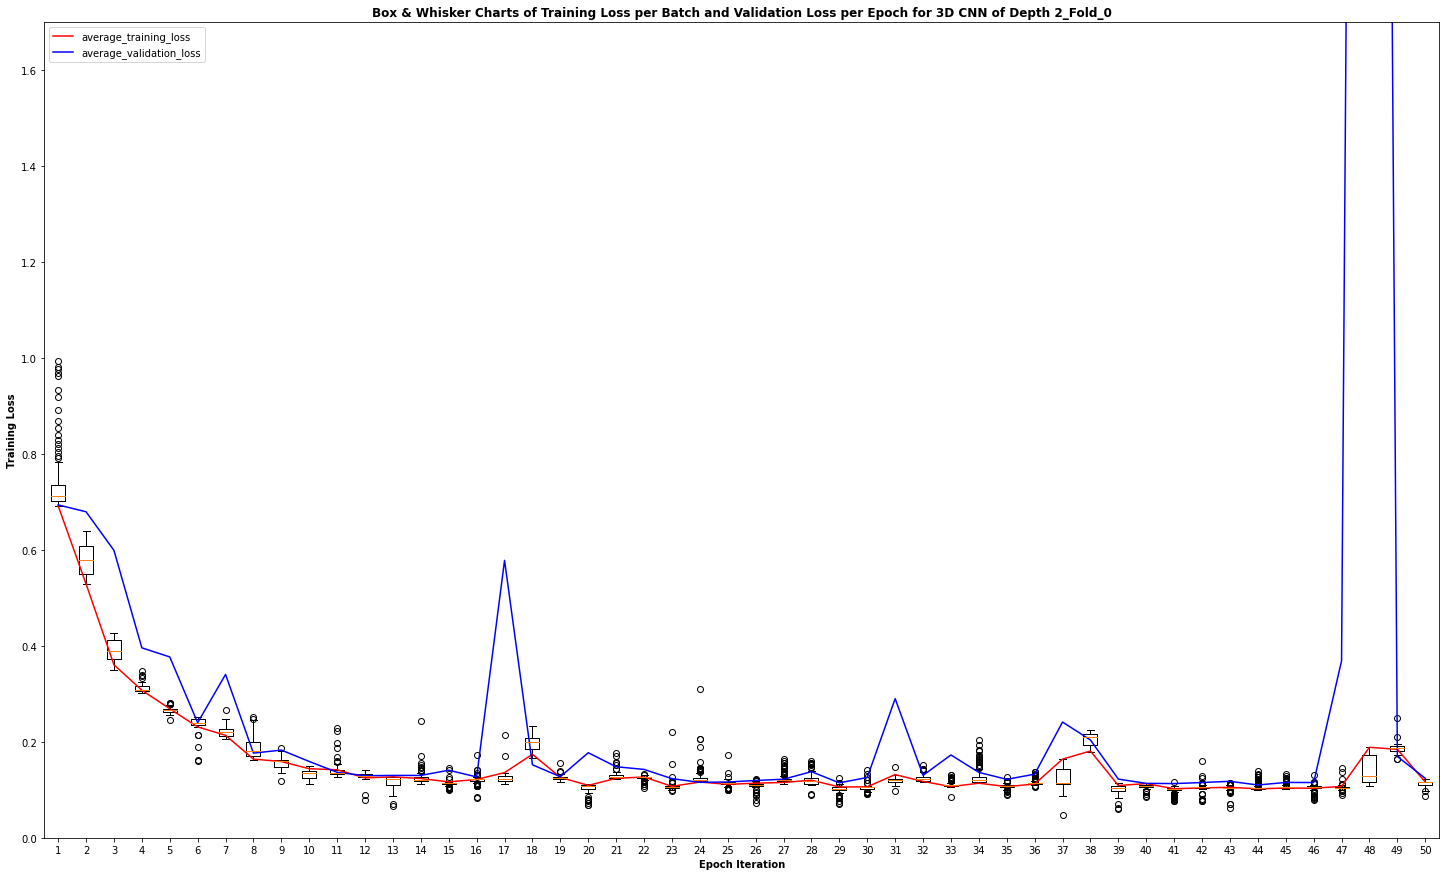

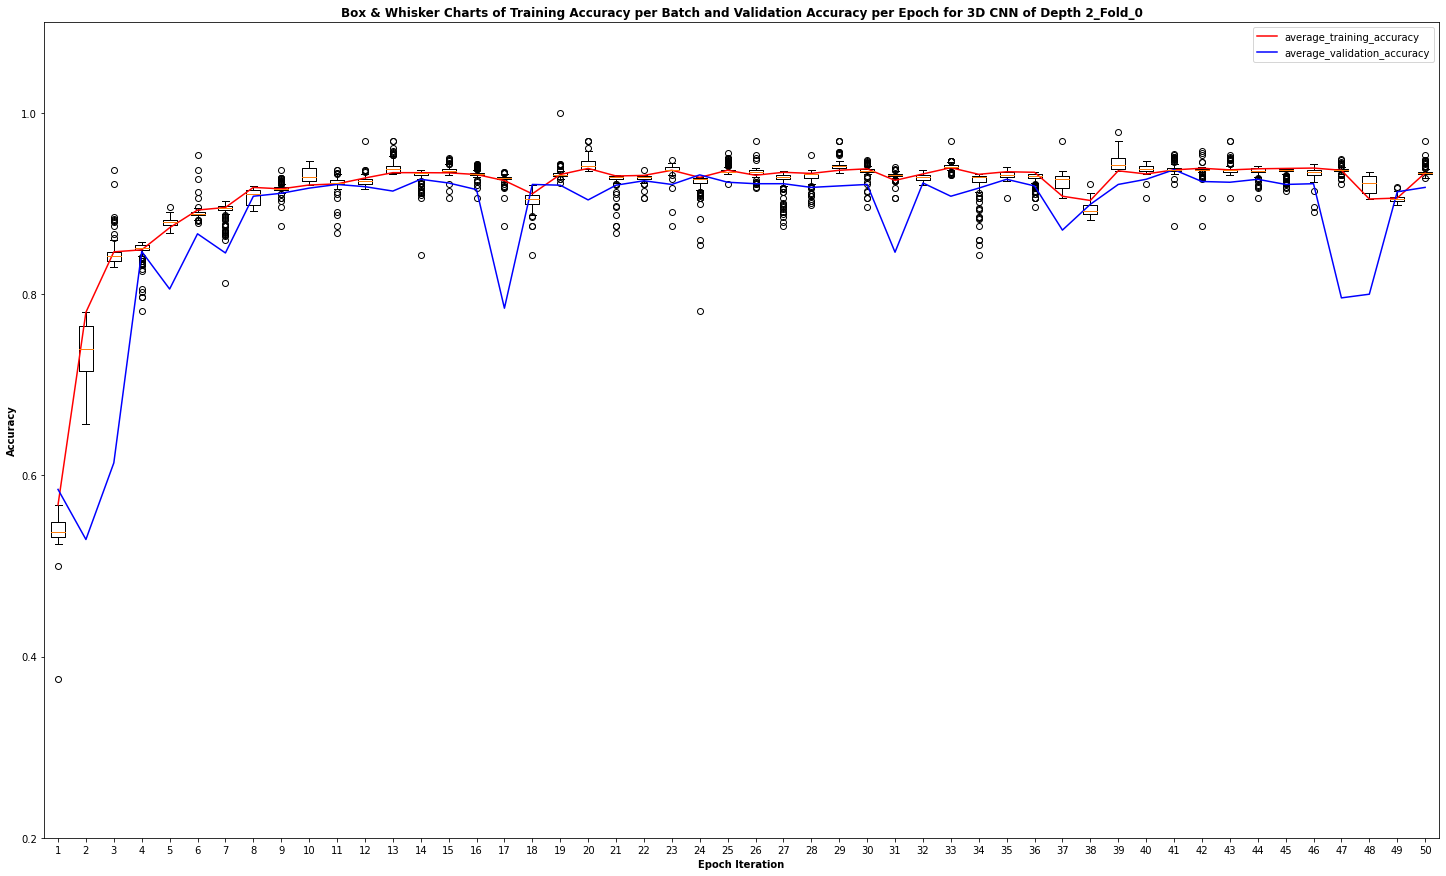

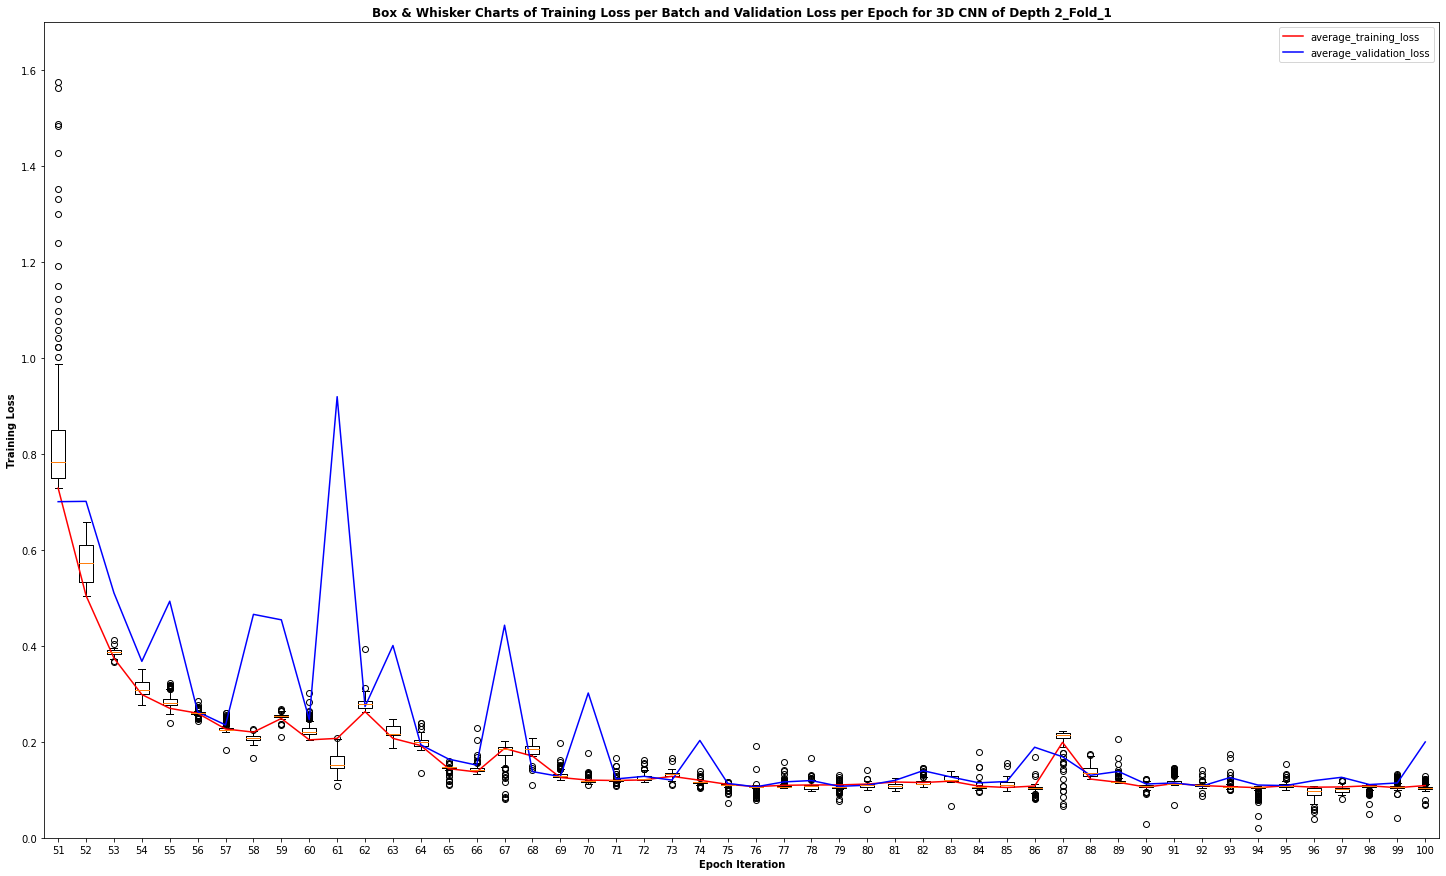

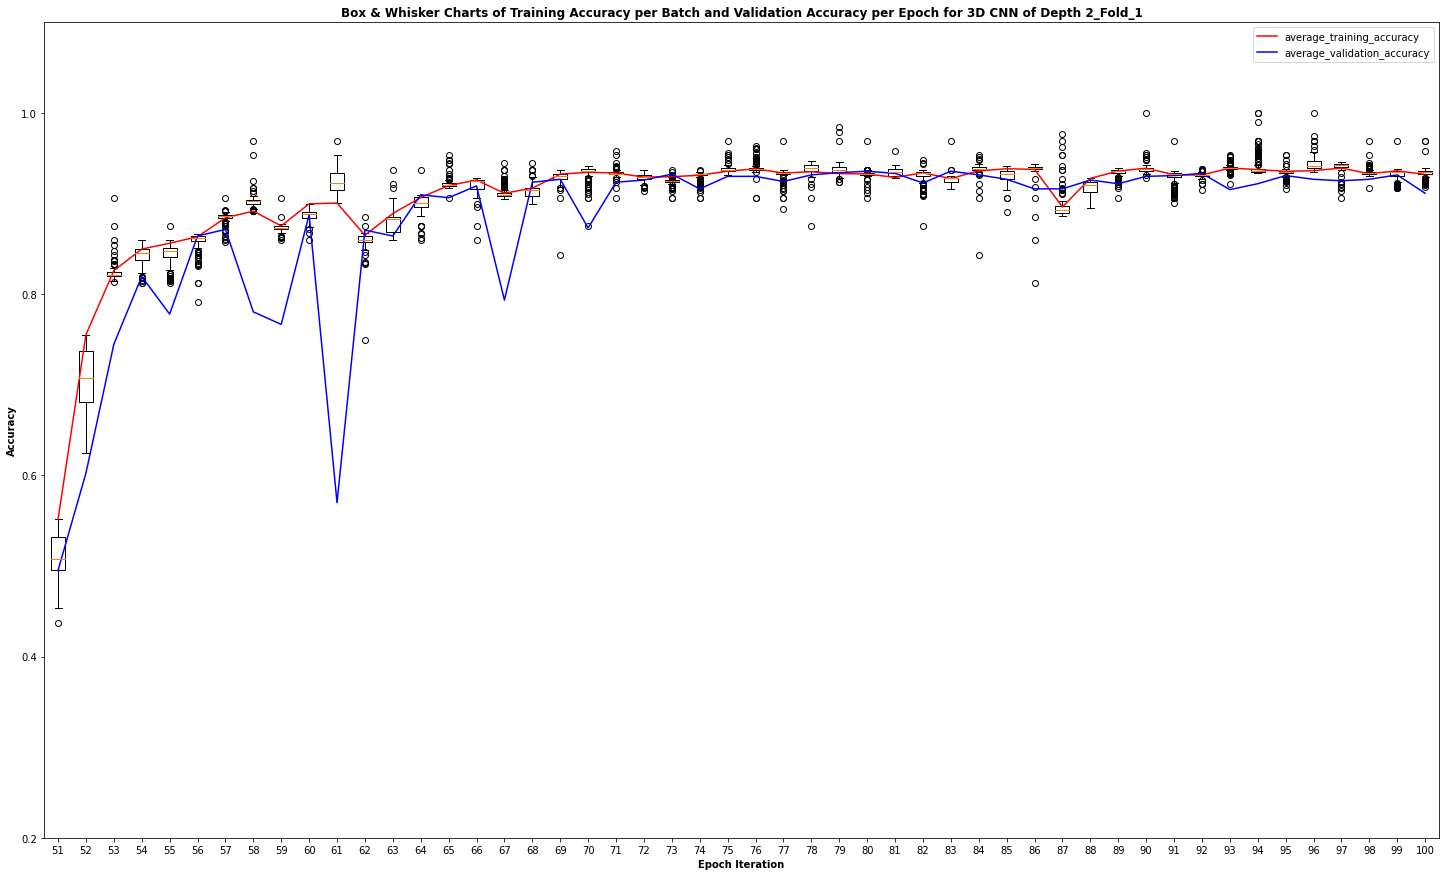

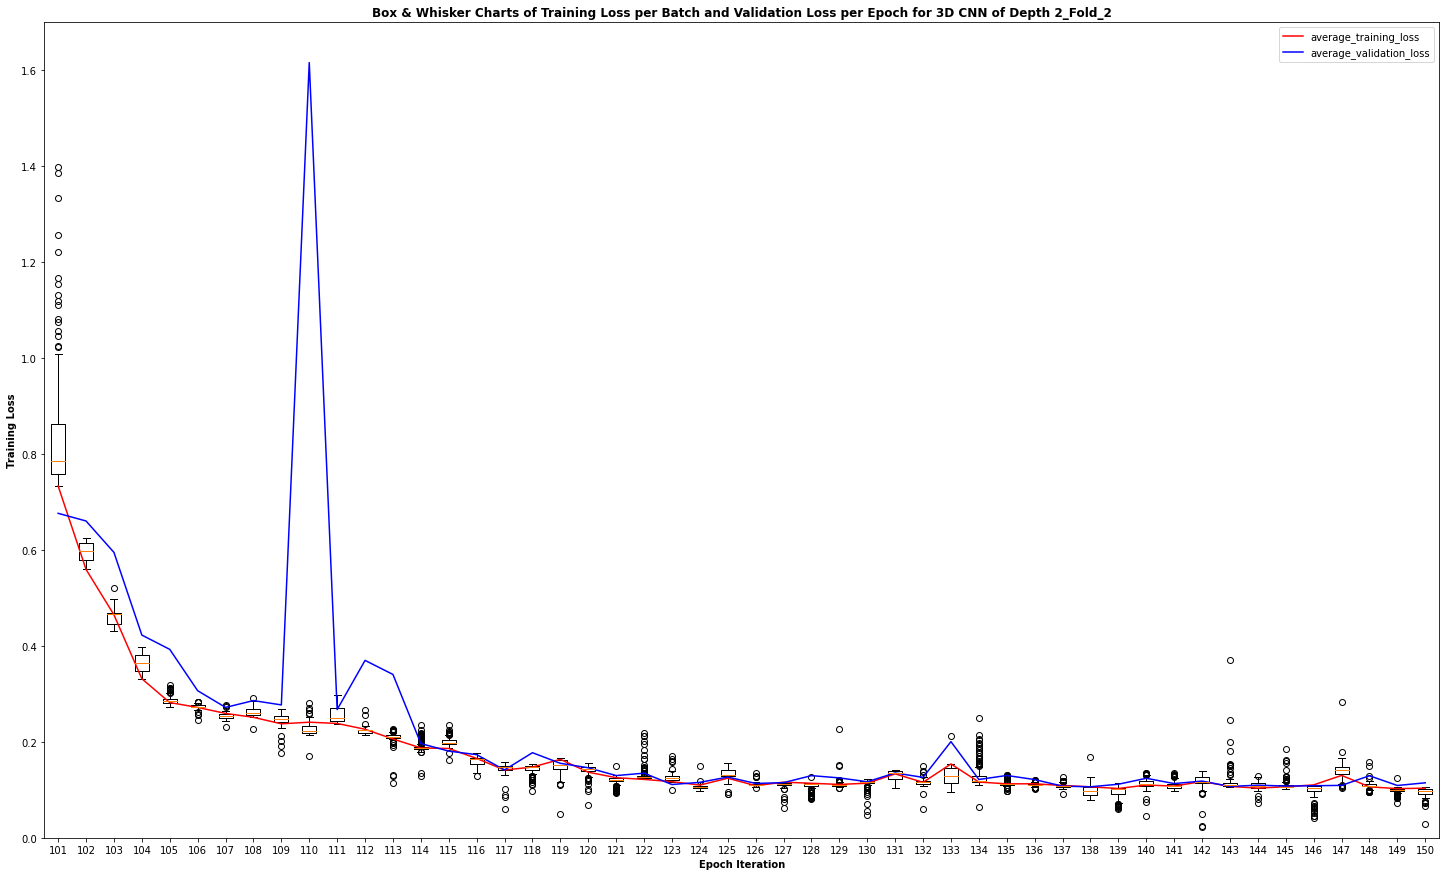

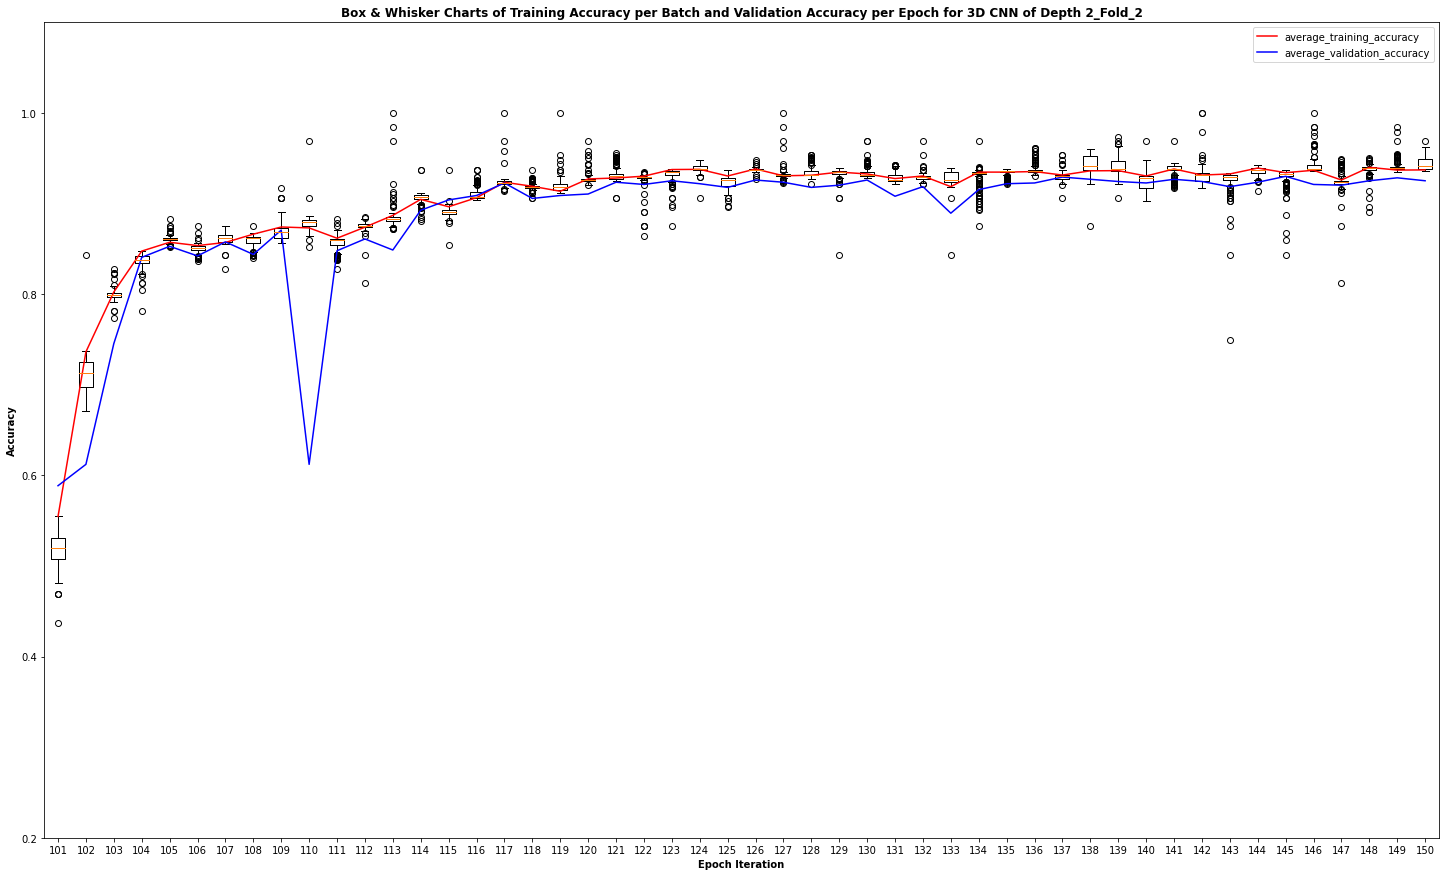

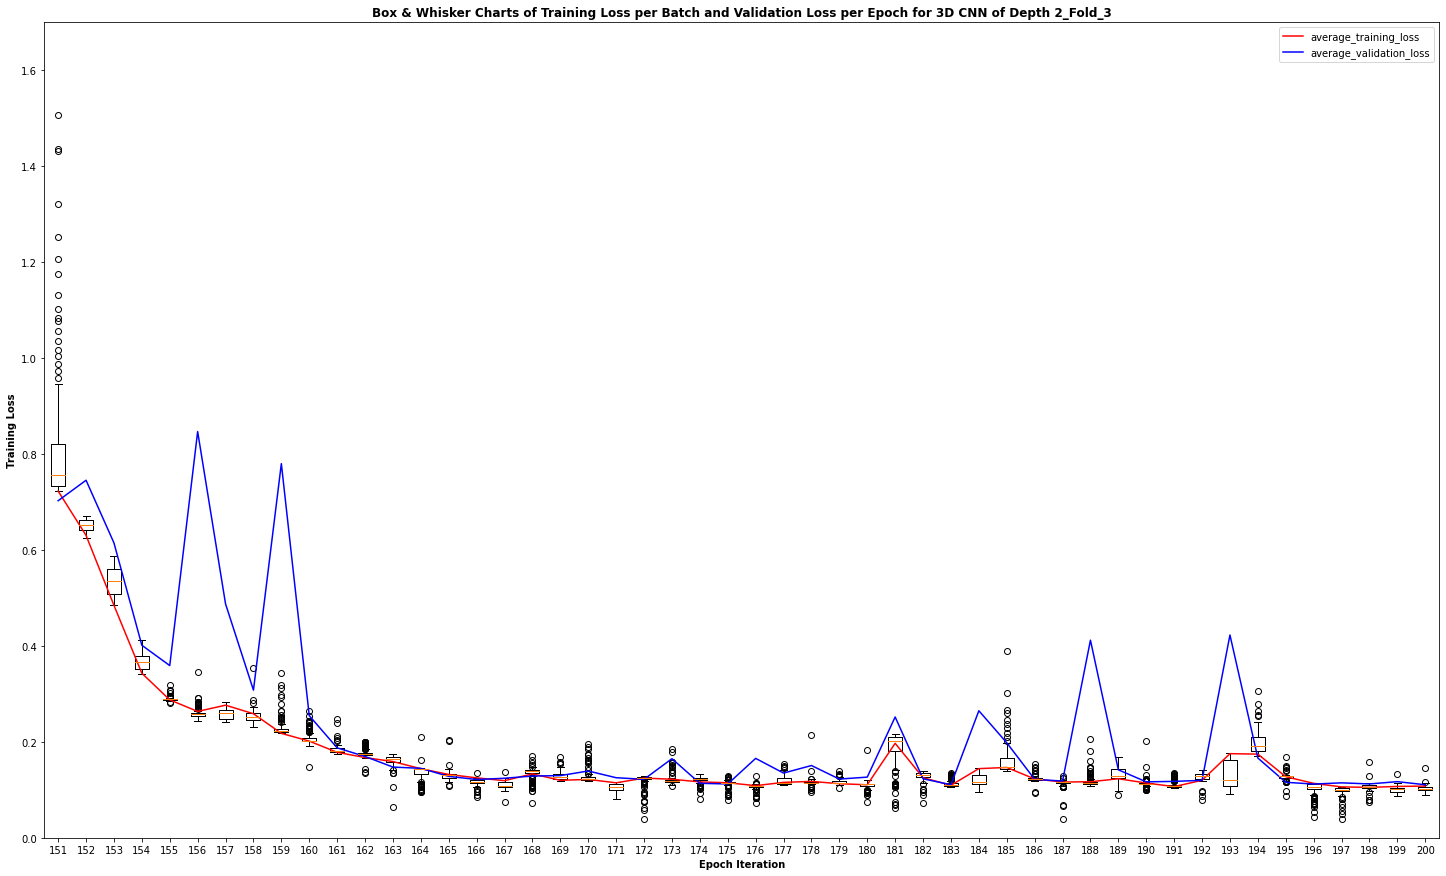

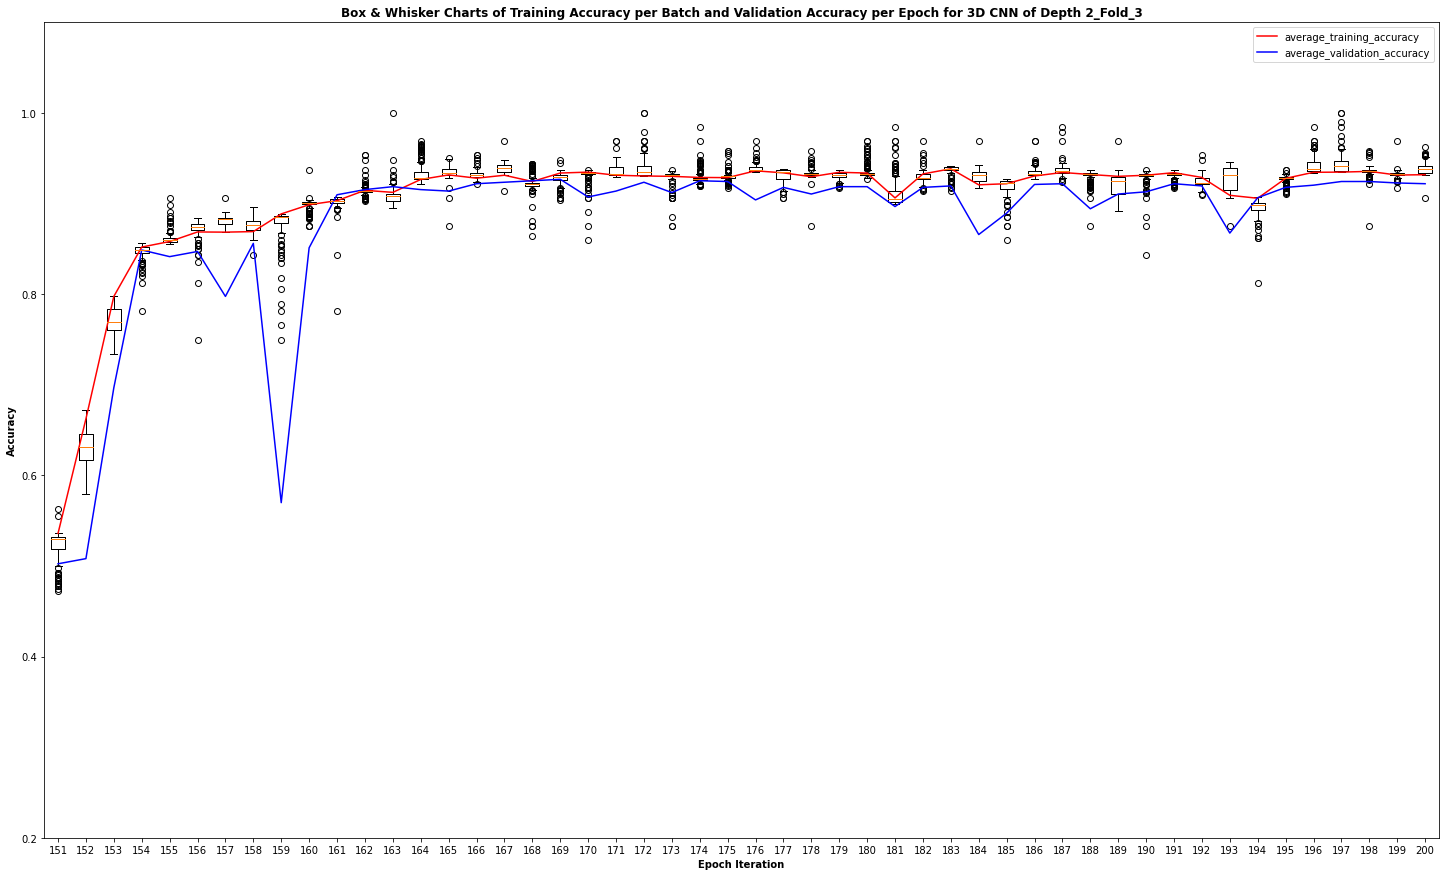

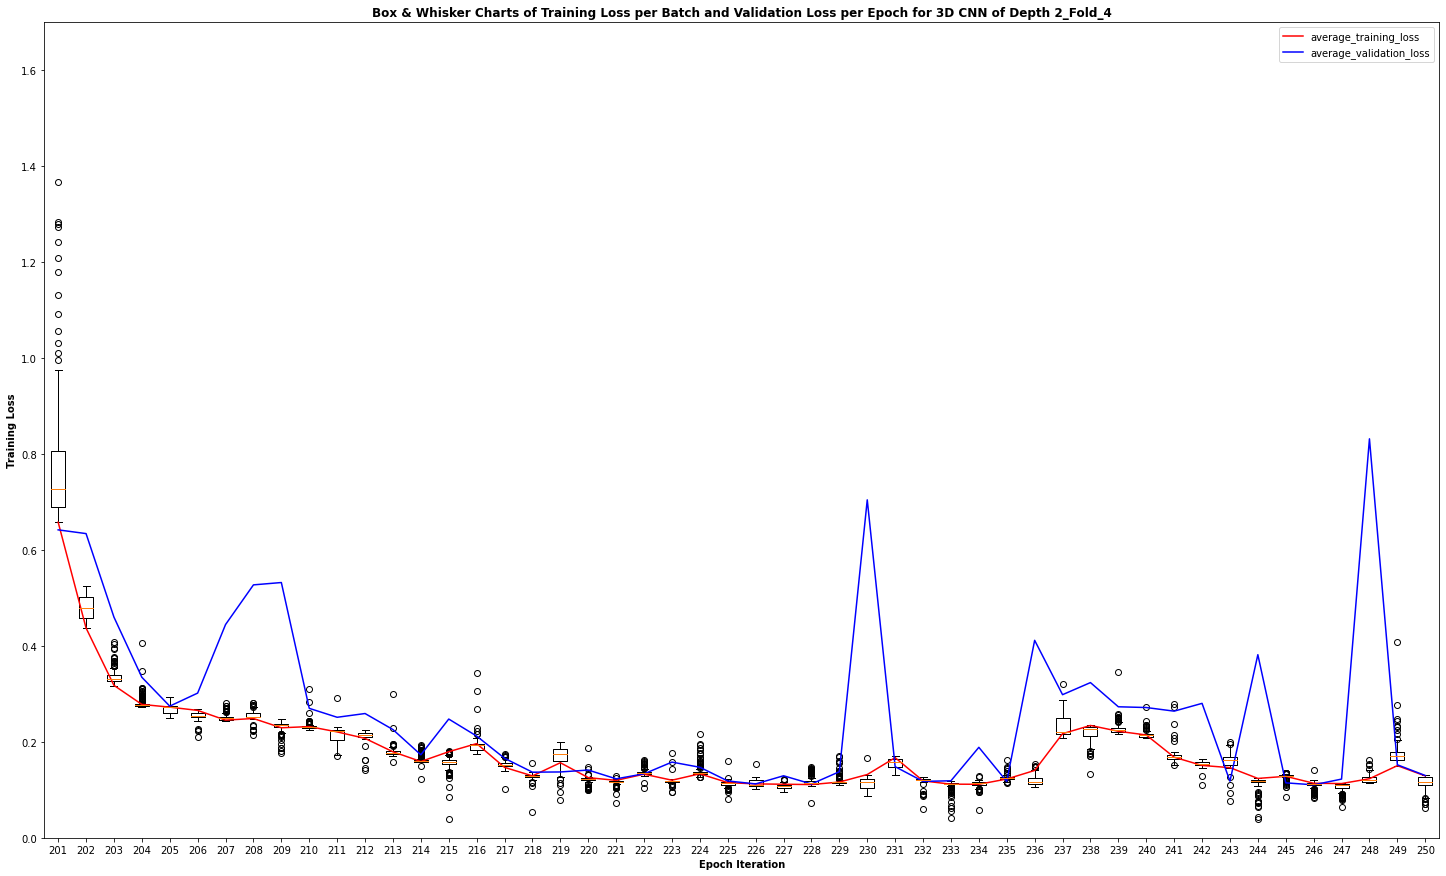

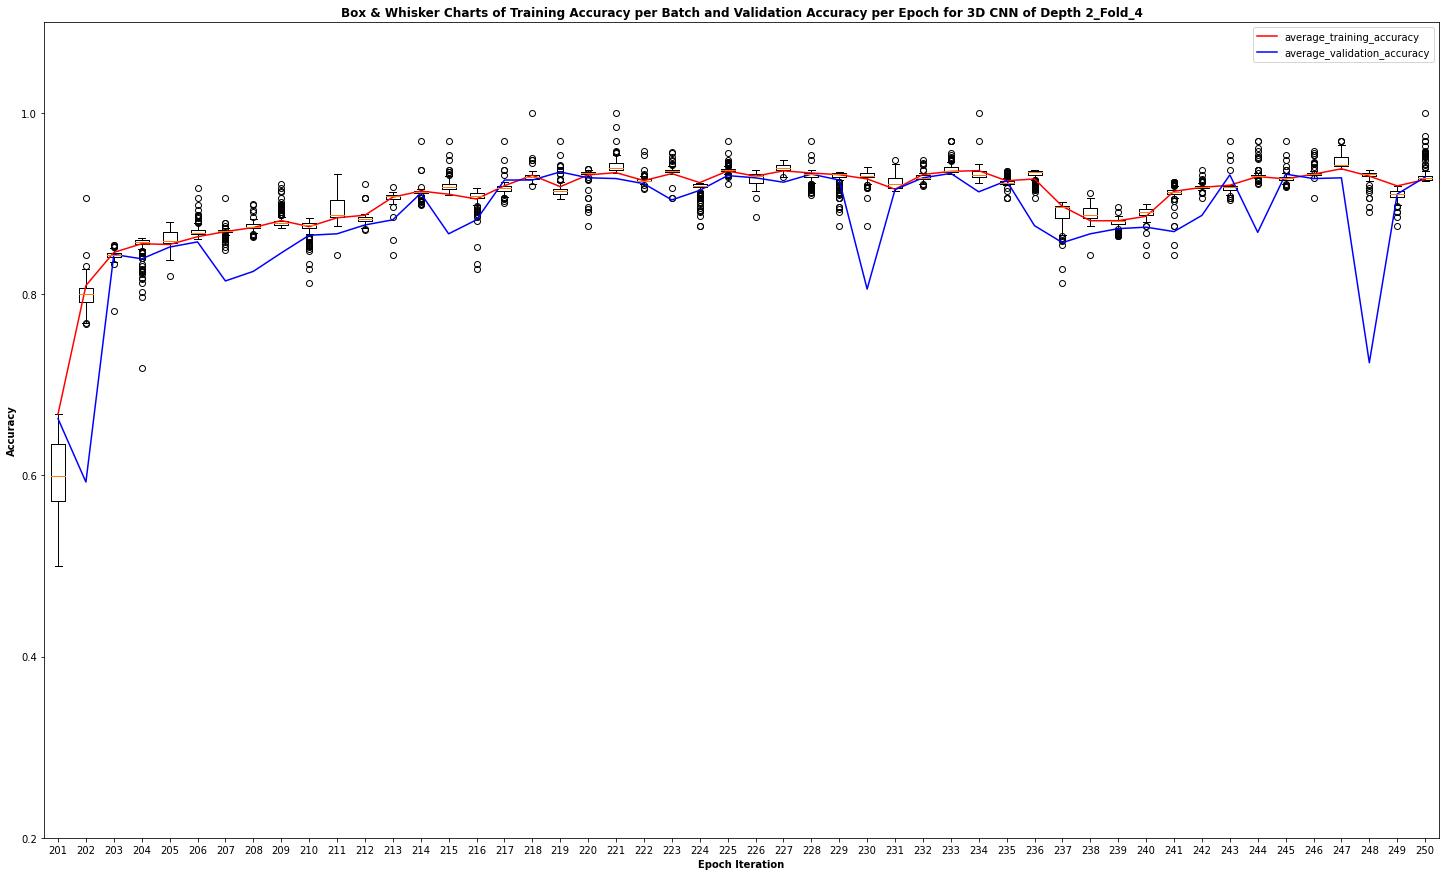

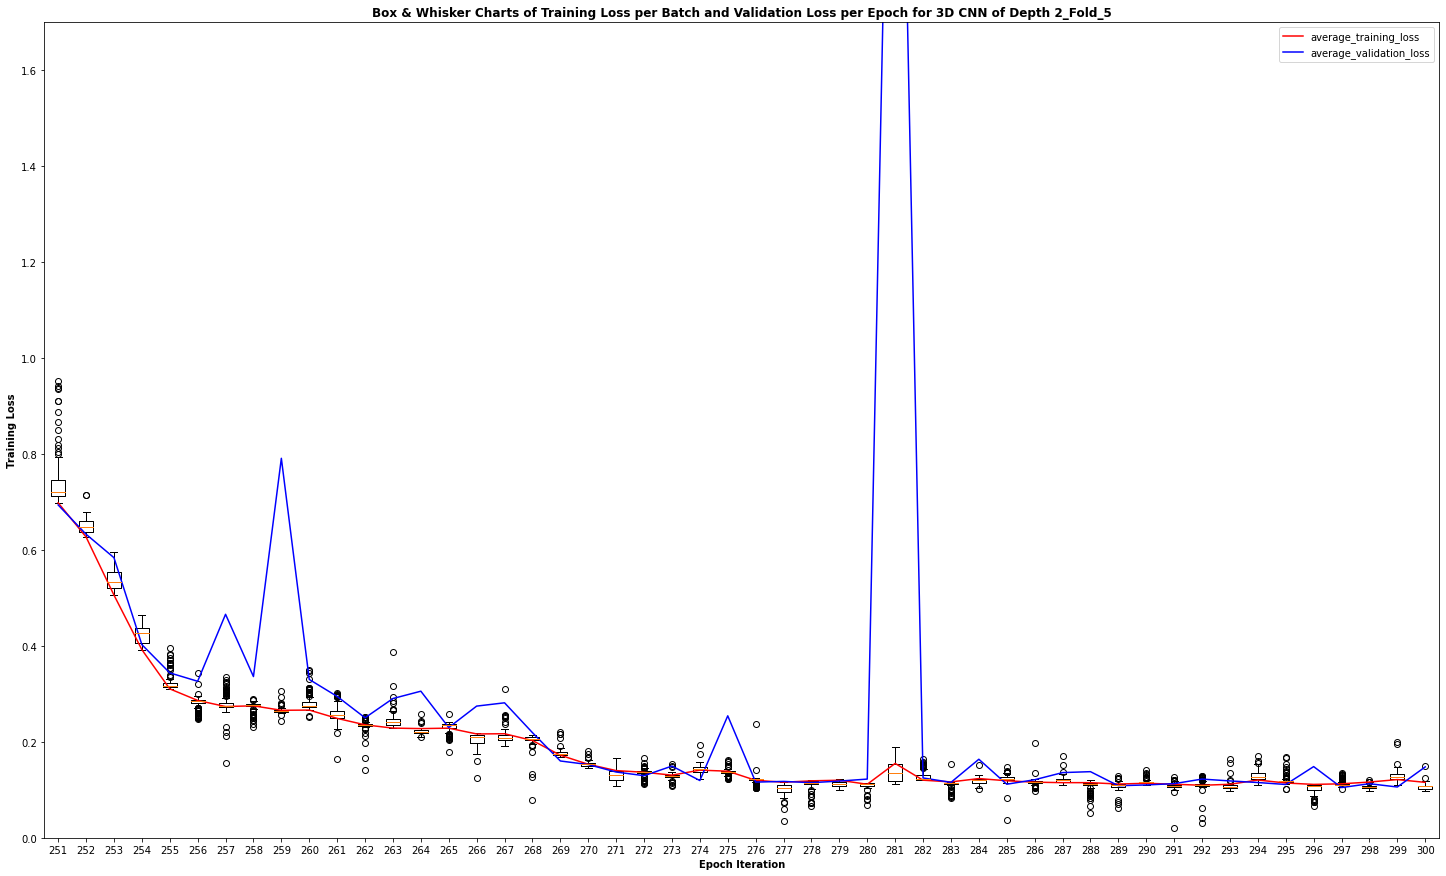

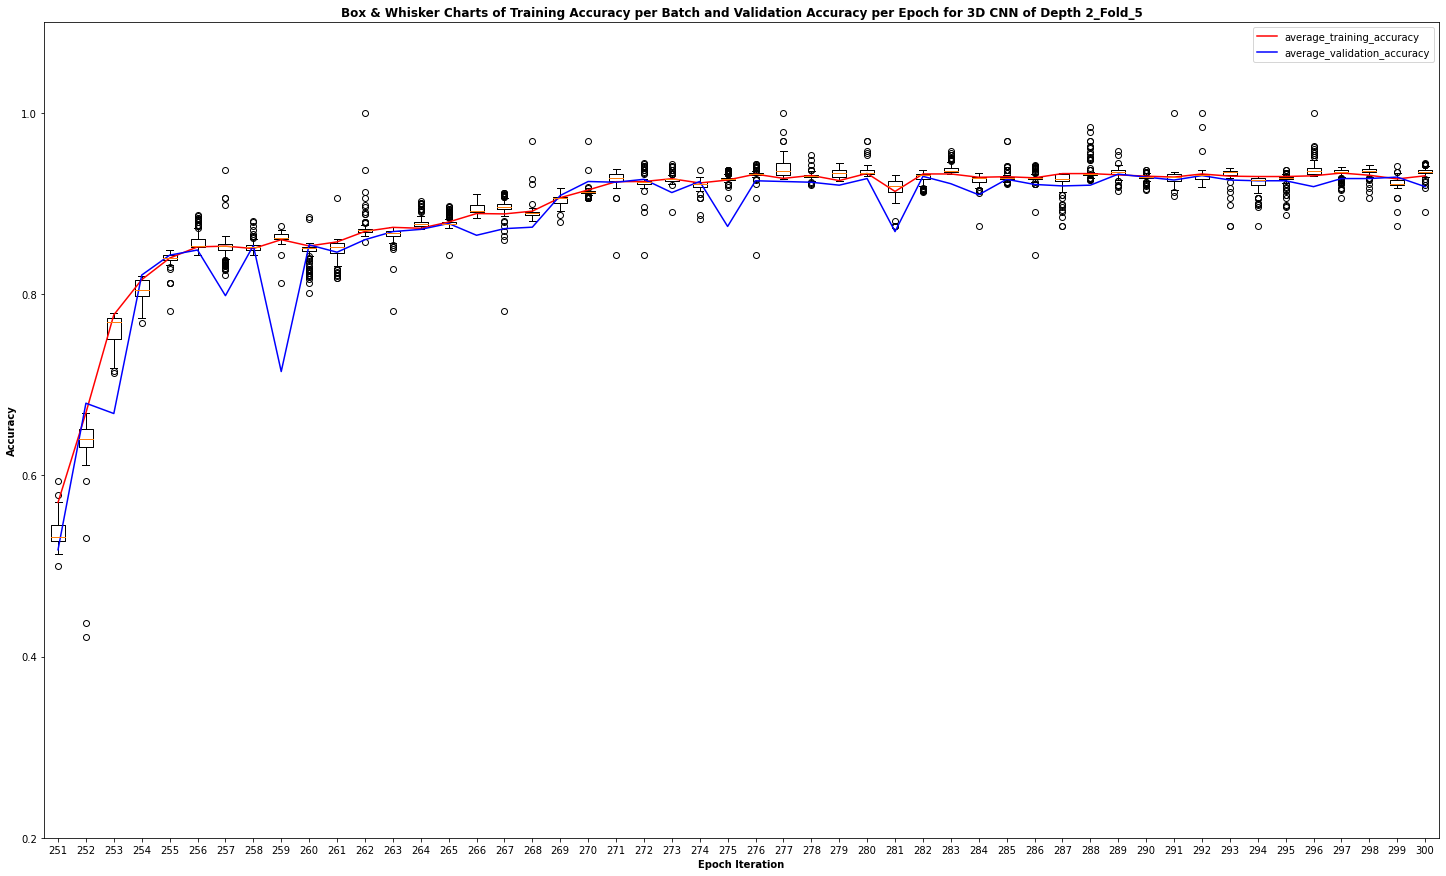

In [19]:
# Plotting the training loss per batch, training loss per epoch and validation loss
  
for i in range(num_folds):
    t = range(1+i*50, 51+i*50) # Number of epochs
    
    fig = plt.figure(figsize = (25, 15))
    ax = fig.add_subplot(111)

    # Creating plot
    plt.boxplot(loss_training[i])
    plt.plot(t, loss_train_average[i], 'red', label = 'average_training_loss')
    plt.plot(t, loss_validation[i], 'blue', label = 'average_validation_loss')

    plt.xlabel('Epoch Iteration', fontweight = 'bold')
    plt.ylabel('Training Loss', fontweight = 'bold')
    plt.title('Box & Whisker Charts of Training Loss per Batch and Validation Loss per Epoch for 3D CNN of Depth '+str(image_depth)+'_Fold_'+str(i), fontweight = 'bold')
    plt.ylim(0, 1.7)
    plt.xlim(0.5+i*50, 50.5+i*50)
    plt.legend()
    plt.savefig('LossAccuracyGraphs/Conv3D_ReferenceFrame/Loss_3D_CNN_ReferenceFrame_Fold_'+str(i)+'.png')
    # plt.show()

    # Plotting the training accuracy per batch, training accuracy per epoch and validation accuracy
    fig = plt.figure(figsize = (25, 15))

    # Creating the plot
    plt.boxplot(acc_training[i])
    plt.plot(t, acc_train_average[i], 'red', label = 'average_training_accuracy')
    plt.plot(t, acc_validation[i], 'blue', label = 'average_validation_accuracy')

    # Setting Label Names
    plt.xlabel('Epoch Iteration', fontweight = 'bold')
    plt.ylabel('Accuracy', fontweight = 'bold')
    plt.title('Box & Whisker Charts of Training Accuracy per Batch and Validation Accuracy per Epoch for 3D CNN of Depth '+str(image_depth)+'_Fold_'+str(i), fontweight = 'bold')
    plt.ylim(0.2, 1.1)
    plt.xlim(0.5+i*50, 50.5+i*50)
    plt.legend()
    plt.savefig('LossAccuracyGraphs/Conv3D_ReferenceFrame/Accuracy_3D_CNN_ReferenceFrame_Fold_'+str(i)+'.png')
    # plt.show()

### **Displaying the Classification Report of the Predicted Model**

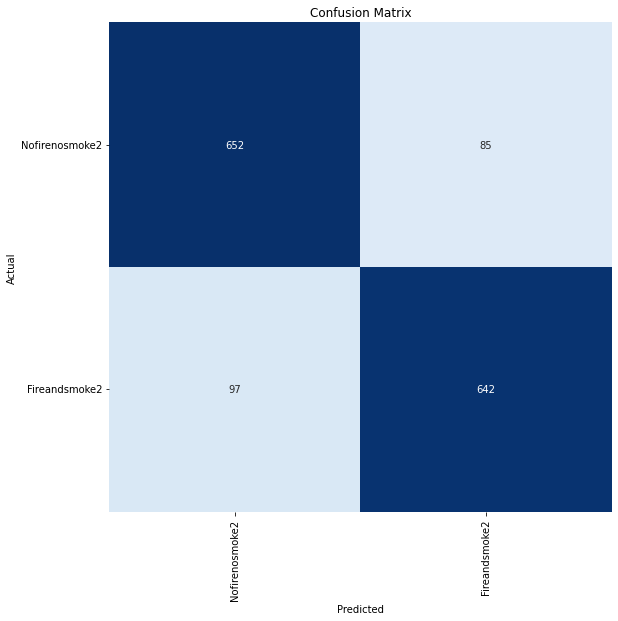


Classification Report for a 3D Convolutional Neural Network

                precision    recall  f1-score   support

Nofirenosmoke2       0.87      0.88      0.88       737
 Fireandsmoke2       0.88      0.87      0.88       739

      accuracy                           0.88      1476
     macro avg       0.88      0.88      0.88      1476
  weighted avg       0.88      0.88      0.88      1476



In [28]:
y_pred = model.predict(features_test, batch_size = 10, verbose = 0)

labels_test_rounded = np.argmax(labels_test, axis = 1)
y_pred_bool = np.argmax(y_pred, axis = 1)

cm = confusion_matrix(labels_test_rounded, y_pred_bool)

import seaborn as sns
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot = True, vmin = 0, fmt = 'g', cmap = 'Blues', cbar = False)       
plt.xticks(np.arange(model_output_size)+.5, classes_list, rotation = 90)
plt.yticks(np.arange(model_output_size)+.5, classes_list, rotation = 0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
# plt.savefig("ConfusionMatrices/Confusion_Matrix_of_3D_FrameReferencing_Model.png")
plt.show()    

print()
print("Classification Report for a 3D Convolutional Neural Network")
print()
print(classification_report(labels_test_rounded, y_pred_bool, target_names = classes_list))


### **Save the Model**
The model can be saved for future runs.

In [46]:
# Creating a useful name for the model, incase multiple models are saved
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_name = f'Models/Model_Conv3D_FrameReferencing_Date_Time_{current_date_time_string}_Loss_{loss}_Accuracy_{accuracy}.h5'

# Saving the Model
model.save(model_name)

## **Step 7: Plot Model’s Loss & Accuracy Curves**
Let's plot our loss and accuracy curves.

In [19]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
    fig = plt.subplots(figsize =(14,  6))
    # Get Metric values using metric names as identifiers
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Constructing a range object which will be used as time 
    epochs = range(len(metric_value_1))
    
    # Plotting the Graph
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    
    # Adding title to the plot
    plt.title(str(plot_name))

    # Adding legend to the plot
    plt.legend()
    plt.savefig("LossAccuracyGraphs/"+ plot_name +".png")

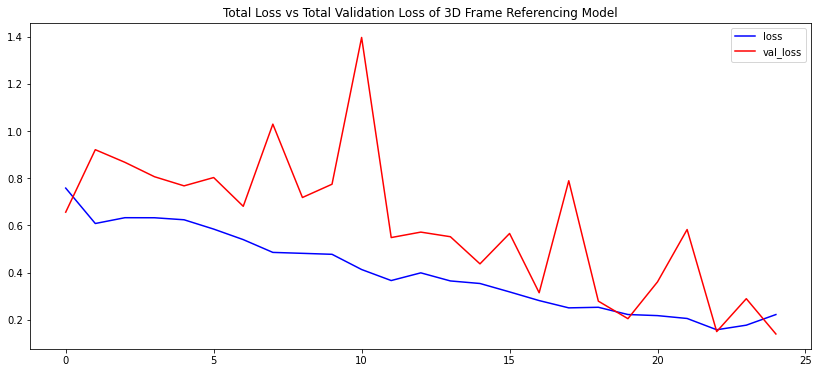

In [21]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss of 3D Frame Referencing Model')

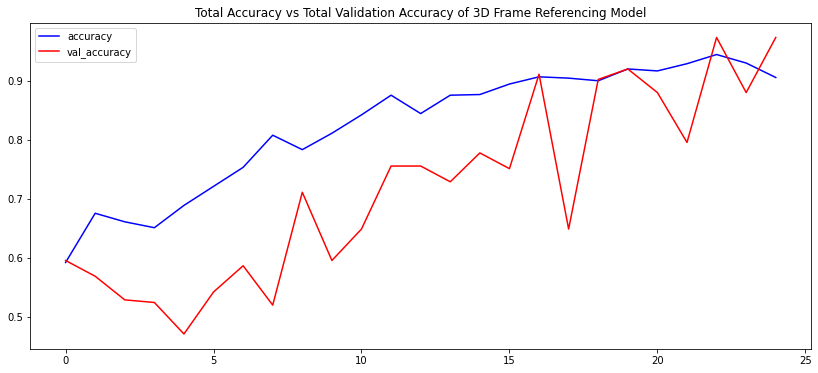

In [22]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy of 3D Frame Referencing Model')

## **Step 8: Make Predictions with the Model:**
Now that the model has been  created and trained it's performance can be tested on some test videos.


### **Function to Download YouTube Videos:**
Various YouTube videos that have been uploaded to my channel will be used. 

The function below *`download_youtube_videos`* uses the *`pafy library`* to download a YouTube video and return it's title by passing through the videos URL.

In [6]:
def download_youtube_videos(youtube_video_url, output_directory):
    # Creating a Video object which includes useful information regarding the youtube video.
    video = pafy.new(youtube_video_url)

    # Getting the best available quality object for the youtube video.
    video_best = video.getbest()

    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'

    # Downloading the youtube video at the best available quality.
    video_best.download(filepath = output_file_path, quiet = True)

    # Returning Video Title
    return video.title

### **Function To Predict on Live Videos Using Moving Average:**
A second function is made to predict each of the frames of the live videos using a moving_average

If the *`window_size`* hyperparameter is set to `1` then the function behavse like a normal classifier to predict on video frames.

In [7]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    original_video_length = int(video_reader.get(cv2. CAP_PROP_FRAME_COUNT))
    print("The Video has a Total Number of Frames of: ", original_video_length)

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 24, (original_video_width, original_video_height))
    
    frames_list1 = []
    frames_window1 = []
    frames_dummy1 = []
    reference_frame1 = []
    fire_and_smoke = []
    no_fire_no_smoke = []
    
    predictions = []
    index = 0
    frame_number = 0
    first_frame = True
    
    # Confusion Matrix Arrays and Variables
    fire = 1
    nofire = 0
    test_labels = []
    y_pred_bool = []
    
    while True: 
        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # add frames to frames window array until depth of image created has been reached
        if first_frame == True:
            reference_frame1.extend(normalized_frame)
            first_frame = False
        
        # Once the maximum sequence length has been reached, add to the frames_list array to be returned
        else:
            frames_window1.append(normalized_frame)
            
            # Create array of 3D frames of size (Image_Height=240)x(Image_width=240)x(Image_depth=4)x(RGB_Channel=3)
            for x in range(image_height):
                frames_dummy1.append([])
                
                for y in range(image_width):
                    frames_dummy1[x].append([])
                    
                    for z in range(image_depth):
                        if z == 0:
                            frames_dummy1[x][y].append(np.asarray(reference_frame1[x][y]))
                        else:
                            frames_dummy1[x][y].append(np.asarray(frames_window1[frame_number][x][y]))
                    
            frames_list1 = (np.asarray(frames_dummy1))
                                             
            frames_dummy1.clear()

            # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_list1, axis = 0), verbose = 0)[0]

            if frame_number <= 60 and video_file_path[15:30] == 'FireSmoke_Test5':
                test_labels.append(nofire)
                y_pred_bool.append(np.argmax(predicted_labels_probabilities))

            elif frame_number <= 82 and video_file_path[15:30] == 'FireSmoke_Test7':
                test_labels.append(nofire)
                y_pred_bool.append(np.argmax(predicted_labels_probabilities))   

            elif frame_number <= 60 and video_file_path[15:30] == 'FireSmoke_Test6':
                test_labels.append(nofire)
                y_pred_bool.append(np.argmax(predicted_labels_probabilities))

            else:
                test_labels.append(fire)
                y_pred_bool.append(np.argmax(predicted_labels_probabilities))
            
            # Appending predicted label probabilities to the deque object
            predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

            frame_number += 1

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)
            predictions.append(predicted_labels_probabilities_np)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
            
            # Sorting the Averaged Predicted Labels Probabilities
            predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

            j = 1  
                #for class_name in classes_list:
            for i in range(len(classes_list)+1):
                y_start = 10
                y_increment = 30
                y = y_start + (j)*y_increment

                if (i < 2):
                        # Overlaying Class Name Text Ontop of the Frame
                    cv2.putText(frame, classes_list[j-1] + " " + str(predicted_labels_probabilities_averaged[j-1]*100)[:6] + "%",
                                (10, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                else:
                        # Overlaying Class Name Text Ontop of the Frame
                    cv2.putText(frame, "Frame Number: " + str(frame_number), 
                                (10, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)     
                j += 1
                
            # Writing The Frame
            video_writer.write(frame)
        
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()
    
    cm = confusion_matrix(test_labels, y_pred_bool)
    
    classes = ["Fire", "No Fire"]
    import seaborn as sns
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot = True, vmin = 0, fmt = 'g', cmap = 'Blues', cbar = False, annot_kws={"weight": "bold"})       
    plt.xticks(np.arange(model_output_size)+.5, classes, rotation = 90, fontsize = 15)
    plt.yticks(np.arange(model_output_size)+.5, classes, rotation = 0, fontsize = 15)
    plt.xlabel("Predicted", fontsize = 18, style='italic', fontweight = 'bold')
    plt.ylabel("Actual", fontsize = 18, style='italic', fontweight = 'bold')
    plt.title("Confusion Matrix of 3D Reference Frame CNN", fontsize = 18, fontweight = 'bold')
    # plt.savefig("ConfusionMatrices/Confusion_Matrix_of_"+video_file_path[15:30]+"_3D_Model_ReferenceFrame.png")
    plt.show()  
    
    print("Classification Report of "+ video_file_path[15:30]+" for a 3D CNN with Frame Referencing")
    print()
    print(classification_report(test_labels, y_pred_bool, target_names = classes_list))
    
    
    # summarize history for accuracy
    for i in range(len(predictions)):
        fire_and_smoke.append(predictions[i][0][1]*100)
        no_fire_no_smoke.append(predictions[i][0][0]*100)
    
         
    # Make the plot
    barWidth = 0.25
    fig = plt.subplots(figsize =(20, 10))
    
    frames = np.arange(len(fire_and_smoke))
    frames1 = [x + barWidth for x in frames]
    
    
    plt.bar(frames, fire_and_smoke, color ='red', width = barWidth,
        edgecolor ='grey', label ='Fire & Smoke')
    plt.bar(frames1, no_fire_no_smoke, color ='blue', width = barWidth,
        edgecolor ='grey', label ='No Fire & No Smoke')
    
    
    # Adding Xticks
    plt.xlabel('Frame Number', fontweight ='bold', fontsize = 15)
    plt.ylabel('Predicted Probability of Class Labels', fontweight ='bold', fontsize = 15)
    plt.title("Frame Predictions of each Class for 2 Attributes")
    plt.legend()
    # plt.savefig('VideoPredictions/Frame_Predicitons_of_'+video_file_path[15:30]+'_for_3D_CNN_ReferenceFrame.png')
    plt.show()
    

### **Download a Test Video:**
A variety of hand selected videos used to test the model's ability to predict videos with differing environments

#### **Test Video 1 - Duplicate in Dataset**

In [8]:
# Loading a saved model
model = load_model('ModelsResults/Conv3D_ReferenceFrame/Model_Conv3D_ReferenceFrame_FoldNo_1_Loss_0.11896153539419174_Accuracy_0.925203263759613.h5', 
                   custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m})

# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=JNj04OzURHk', output_directory) # FireSmoke_Test1

# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

The Video has a Total Number of Frames of:  122


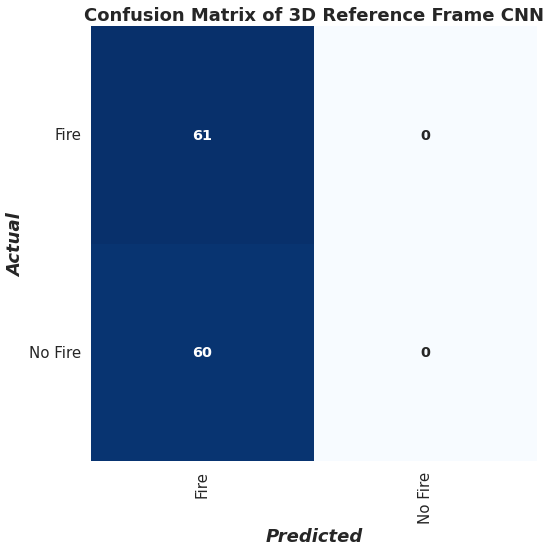

Classification Report of FireSmoke_Test5 for a 3D CNN with Frame Referencing

                precision    recall  f1-score   support

Nofirenosmoke2       0.50      1.00      0.67        61
 Fireandsmoke2       0.00      0.00      0.00        60

      accuracy                           0.50       121
     macro avg       0.25      0.50      0.34       121
  weighted avg       0.25      0.50      0.34       121



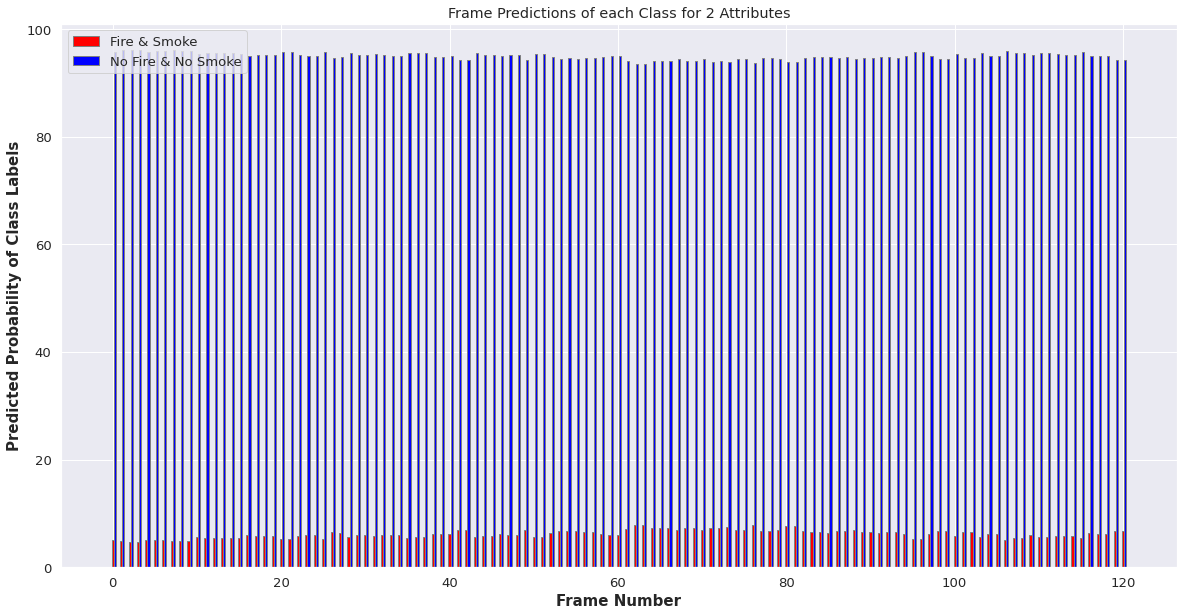

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



TypeError: must be real number, not NoneType

In [9]:
# Setting sthe Widow Size which will be used by the Rolling Averge Proces
window_size = 1

# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title}_3D_FrameReferencing_CNN.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700, maxduration = 120)

#### **Test Video 2 - Clouds & Mist**

In [ ]:
# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
video_title = download_youtube_videos('https://youtu.be/MqRgV0EnDXg', output_directory) # FireSmoke_Test2_Clouds

# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

In [ ]:
# Setting sthe Widow Size which will be used by the Rolling Averge Proces
window_size = 1

# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title}_3D_FrameReferencing_CNN.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
# VideoFileClip(output_video_file_path).ipython_display(width = 700)
VideoFileClip(output_video_file_path).ipython_display(width = 700, maxduration = 340) # change duration to 2 mins

#### **Test Video 3 - Small & Obscured Smoke**

In [ ]:
# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
video_title = download_youtube_videos('https://youtu.be/wTue6FqTYGY', output_directory) # FireSmoke_Test3_Small

# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

In [ ]:
# Setting sthe Widow Size which will be used by the Rolling Averge Proces
window_size = 1

# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title}_3D_FrameReferencing_CNN.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
# VideoFileClip(output_video_file_path).ipython_display(width = 700)
VideoFileClip(output_video_file_path).ipython_display(width = 700, maxduration = 340) # change duration to 2 mins

#### **Test Video 4 - Sun Shining**

## **Using Grad CAM to Visualise the Networks Learning:**

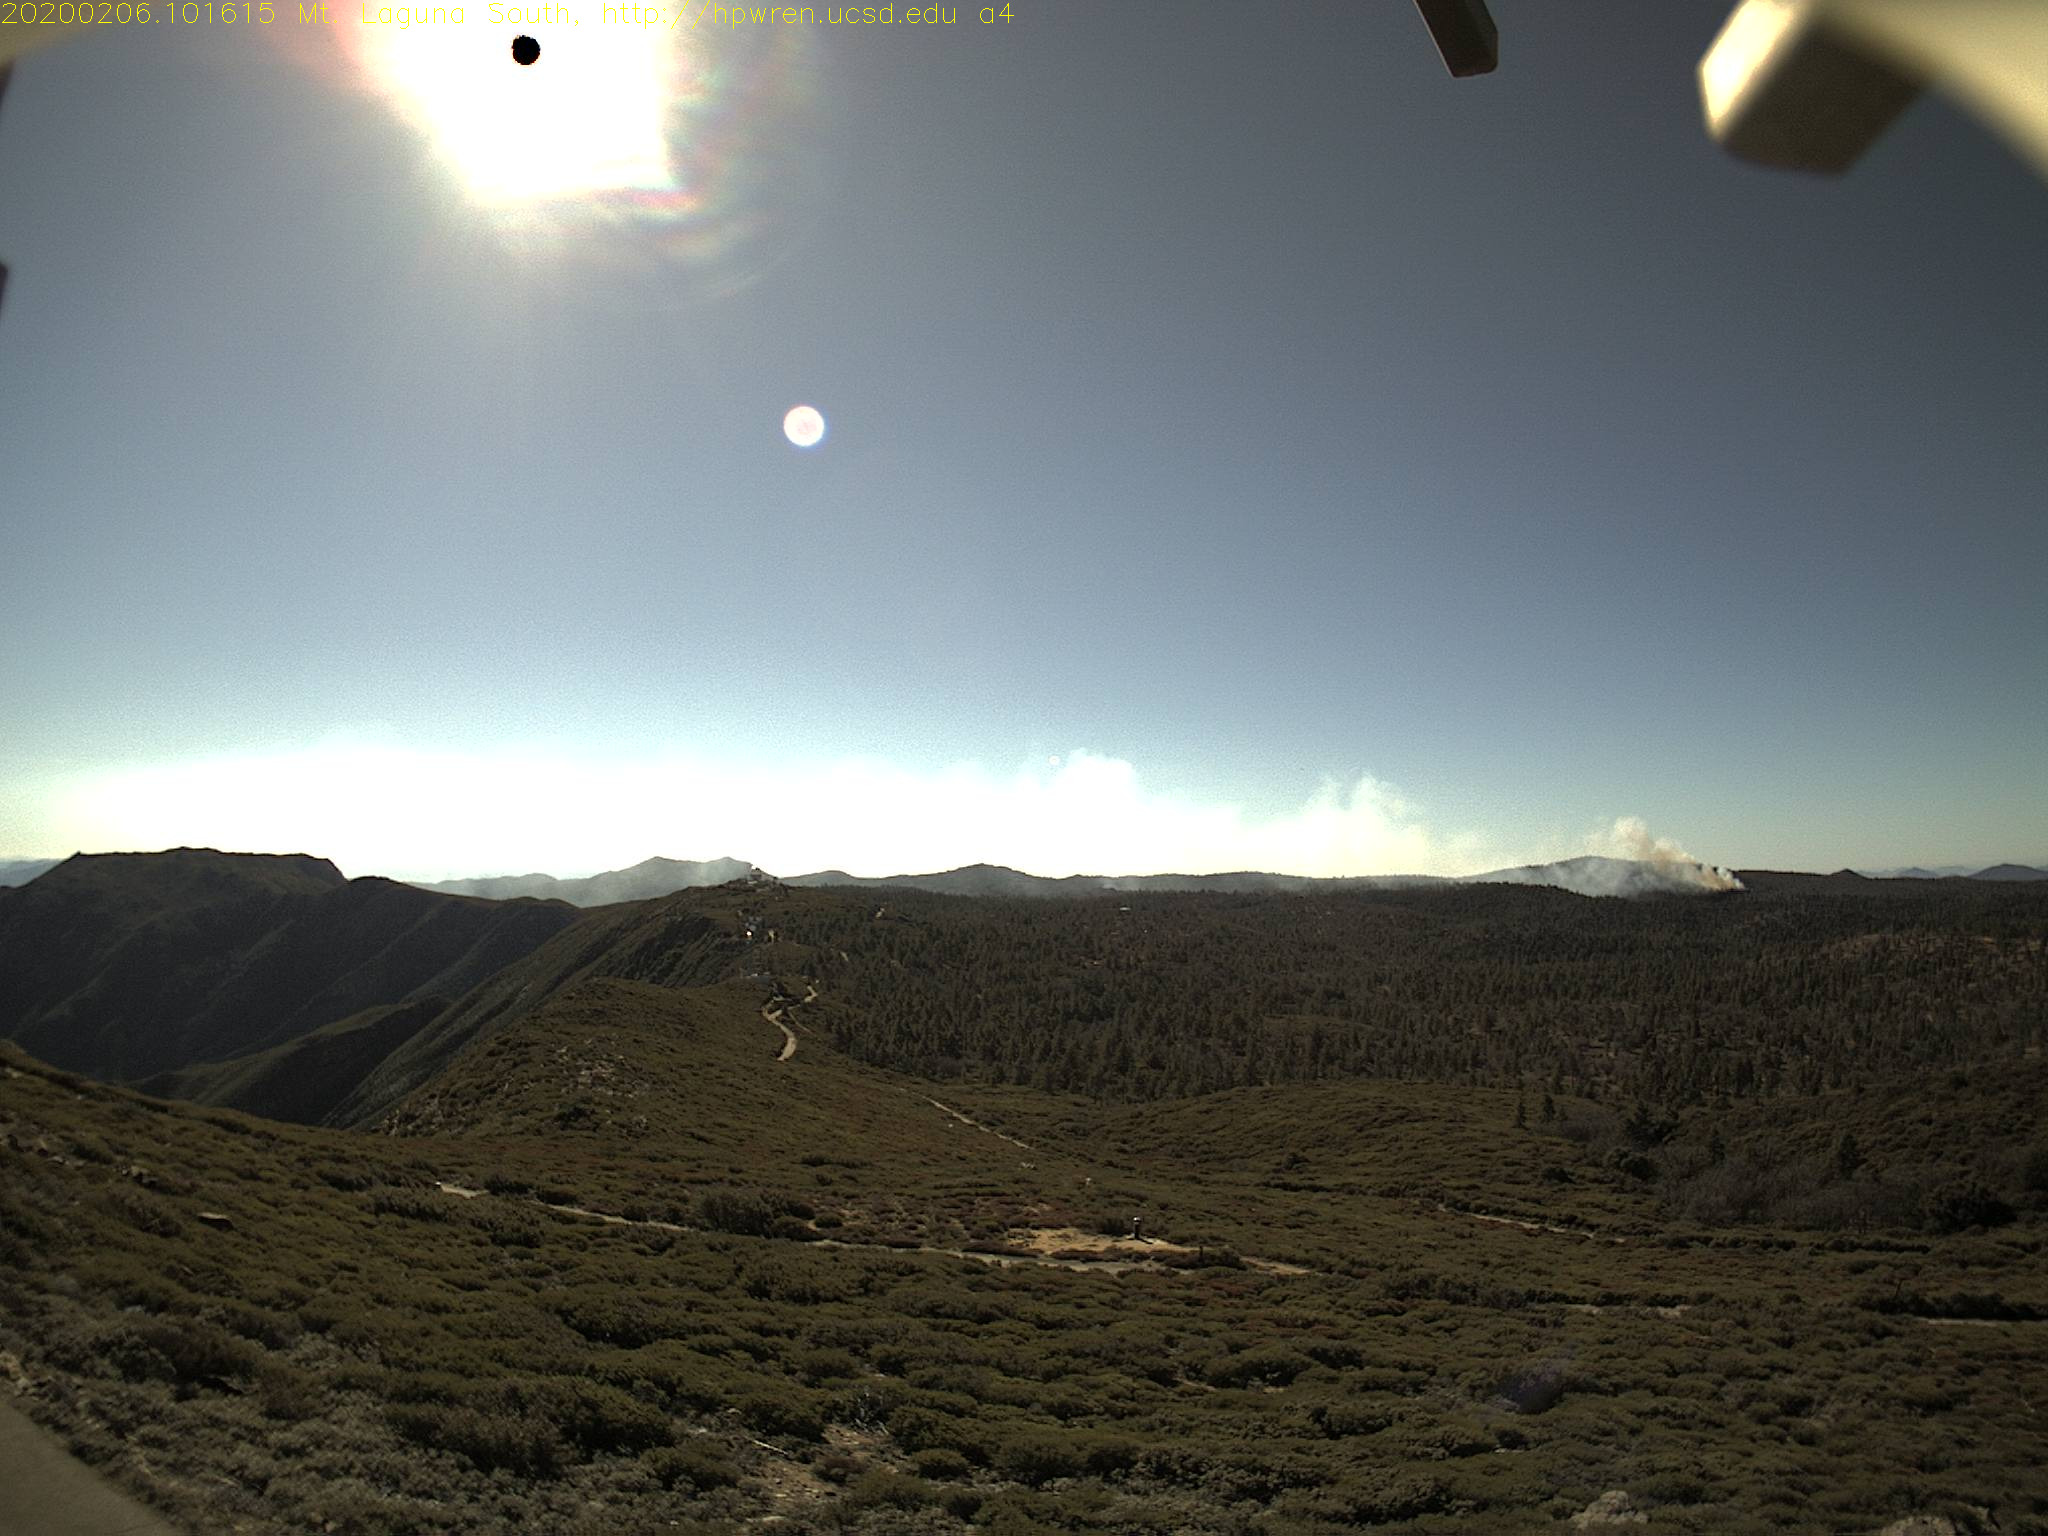

In [41]:
model_builder = keras.applications.xception.Xception
img_size = (image_height, image_width)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_3"

# The local path to our target image
img_path = keras.utils.get_file(
    "firesmoke.jpg", "http://hpwren.ucsd.edu/HPWREN-FIgLib/HPWREN-FIgLib-Data/20200206_FIRE_ml-s-mobo-c/1581012975_+01860.jpg"
)

display(Image(img_path))

In [36]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 18ms/step


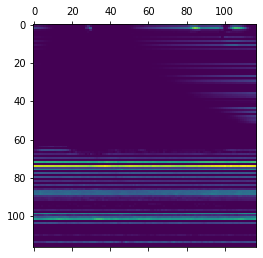

In [42]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

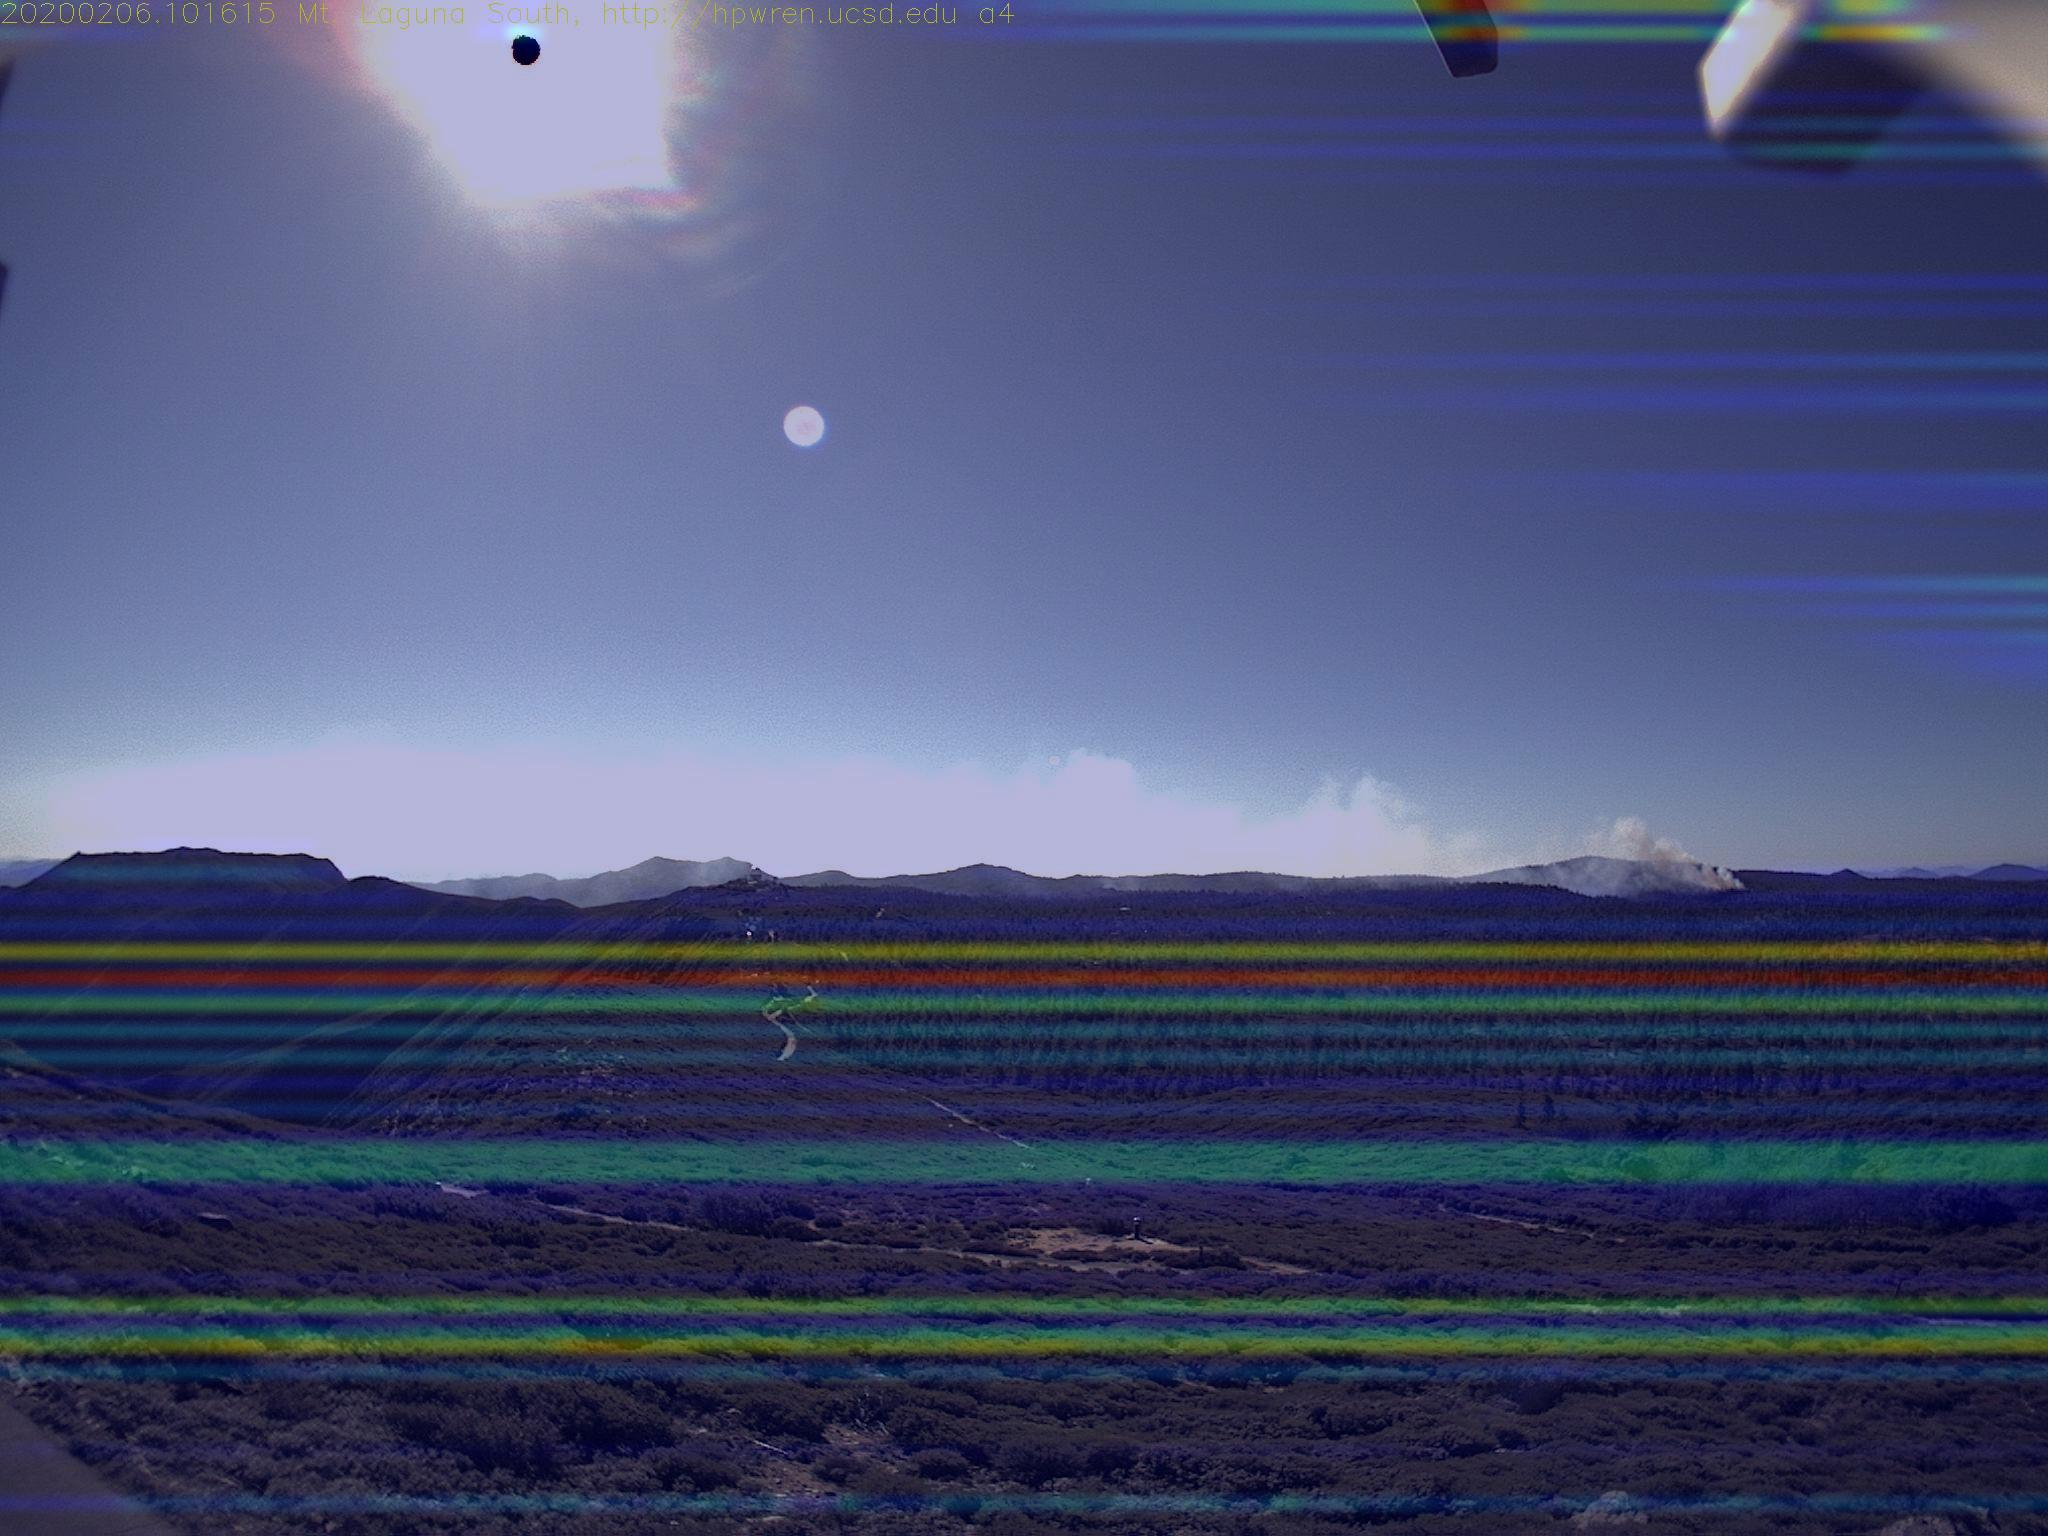

In [43]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

Although the results, are not perfect but you can clearly see that it's much better than the previous approach of predicting on each frame independently.

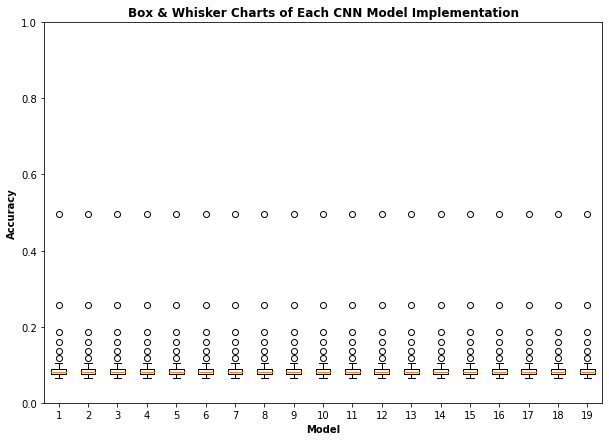

In [37]:
fig = plt.figure(figsize = (10, 7))

ax = fig.add_subplot(111)
 
# Creating plot
plt.boxplot(loss_per_fold)
plt.xlabel('Model', fontweight = 'bold')
plt.ylabel('Accuracy', fontweight = 'bold')

# ax.set_xticklabels(['Conv3D', 'Conv2D', 'Conv3D_Augmentation', 'Conv2D_3D', 'Conv3D_Frame_Referencing'])

plt.title('Box & Whisker Charts of Each CNN Model Implementation', fontweight = 'bold')
plt.ylim(0, 1)
plt.savefig('4_models.png')
plt.show()